# Fate restriction

In [133]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp
from tqdm import tqdm

sys.path.append("/home/sergey/tools/sclitr/")
import sclitr as sl

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

In [2]:
adata = sc.read_h5ad(f"{DATA_PATH}/anndatas/trunk_E13_reference.h5ad")
adata = adata[~adata.obs.celltype_l2.isin(["Doublets", "Doublet"])]

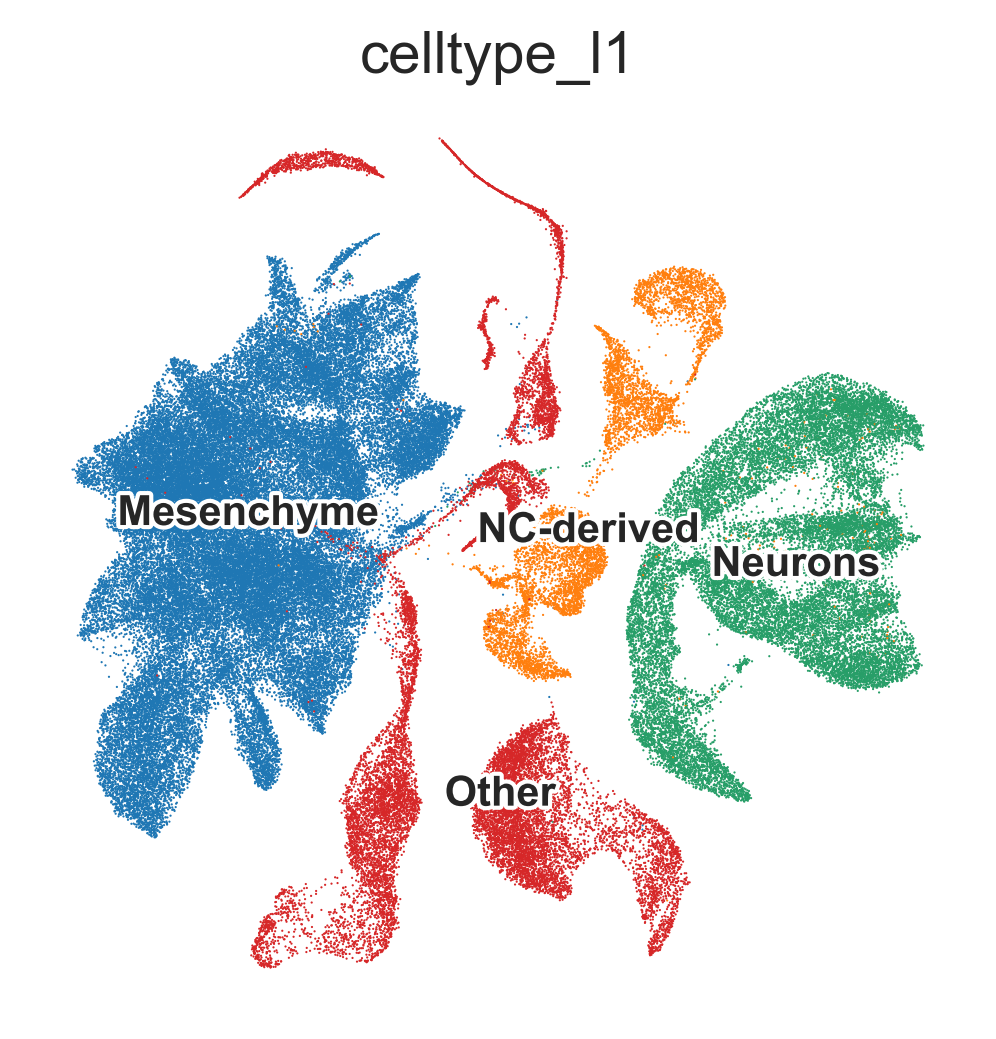

In [24]:
mesenchymal = list(set(pd.read_csv(
    "../01_Embedding_construction/Cell_type_tables/trunk_mes.tsv",
    sep="\t",
    names=["ct_l3", "ct_l2"],
).ct_l2))

neuronal = list(set(pd.read_csv(
    "../01_Embedding_construction/Cell_type_tables/trunk_neurons.tsv",
    sep="\t",
    names=["ct_l3", "ct_l2"],
).ct_l2))
neuronal.remove("Sensory")
neuronal.remove("Melanocytes")
neuronal.remove("Chromaffin cells")

nc = list(set(pd.read_csv(
    "../01_Embedding_construction/Cell_type_tables/trunk_glia.tsv",
    sep="\t",
    names=["ct_l3", "ct_l2"],
).ct_l2)) + ["Sensory", "Melanocytes"]

other = list(set(pd.read_csv(
    "../01_Embedding_construction/Cell_type_tables/trunk_other.tsv",
    sep="\t",
    names=["ct_l3", "ct_l2"],
).ct_l2))

ct_l1 = dict(zip(
    mesenchymal + neuronal + nc + other,
    (
        len(mesenchymal) * ["Mesenchyme"] + 
        len(neuronal) * ["Neurons"] + 
        len(nc) * ["NC-derived"] + 
        len(other) * ["Other"]
    )
))
adata.obs["celltype_l1"] = [ct_l1[ct] for ct in adata.obs.celltype_l2]
sc.pl.umap(adata, color="celltype_l1", frameon=False, legend_loc="on data", legend_fontoutline=2, legend_fontsize=10)
adata_nnc = adata[adata.obs.celltype_l1.isin(["Neurons", "NC-derived"])]

In [82]:
def num_shared(df, column_clone, column_ct="celltype_l1"):
    num_shared = 0
    for clone in set(df[column_clone]):
        cts = set(df[df[column_clone] == clone][column_ct])
        if len(cts) == 2:
            num_shared += 1
    return num_shared

In [129]:
df_E7 = adata_nnc[adata_nnc.obs["E7.5:clones"] != "NA"].obs[["E7.5:clones", "celltype_l1", "batch"]]
df_E8 = adata_nnc[adata_nnc.obs["E8.5:clones"] != "NA"].obs[["E8.5:clones", "celltype_l1", "batch"]]

100%|██████████| 100/100 [00:03<00:00, 32.58it/s]


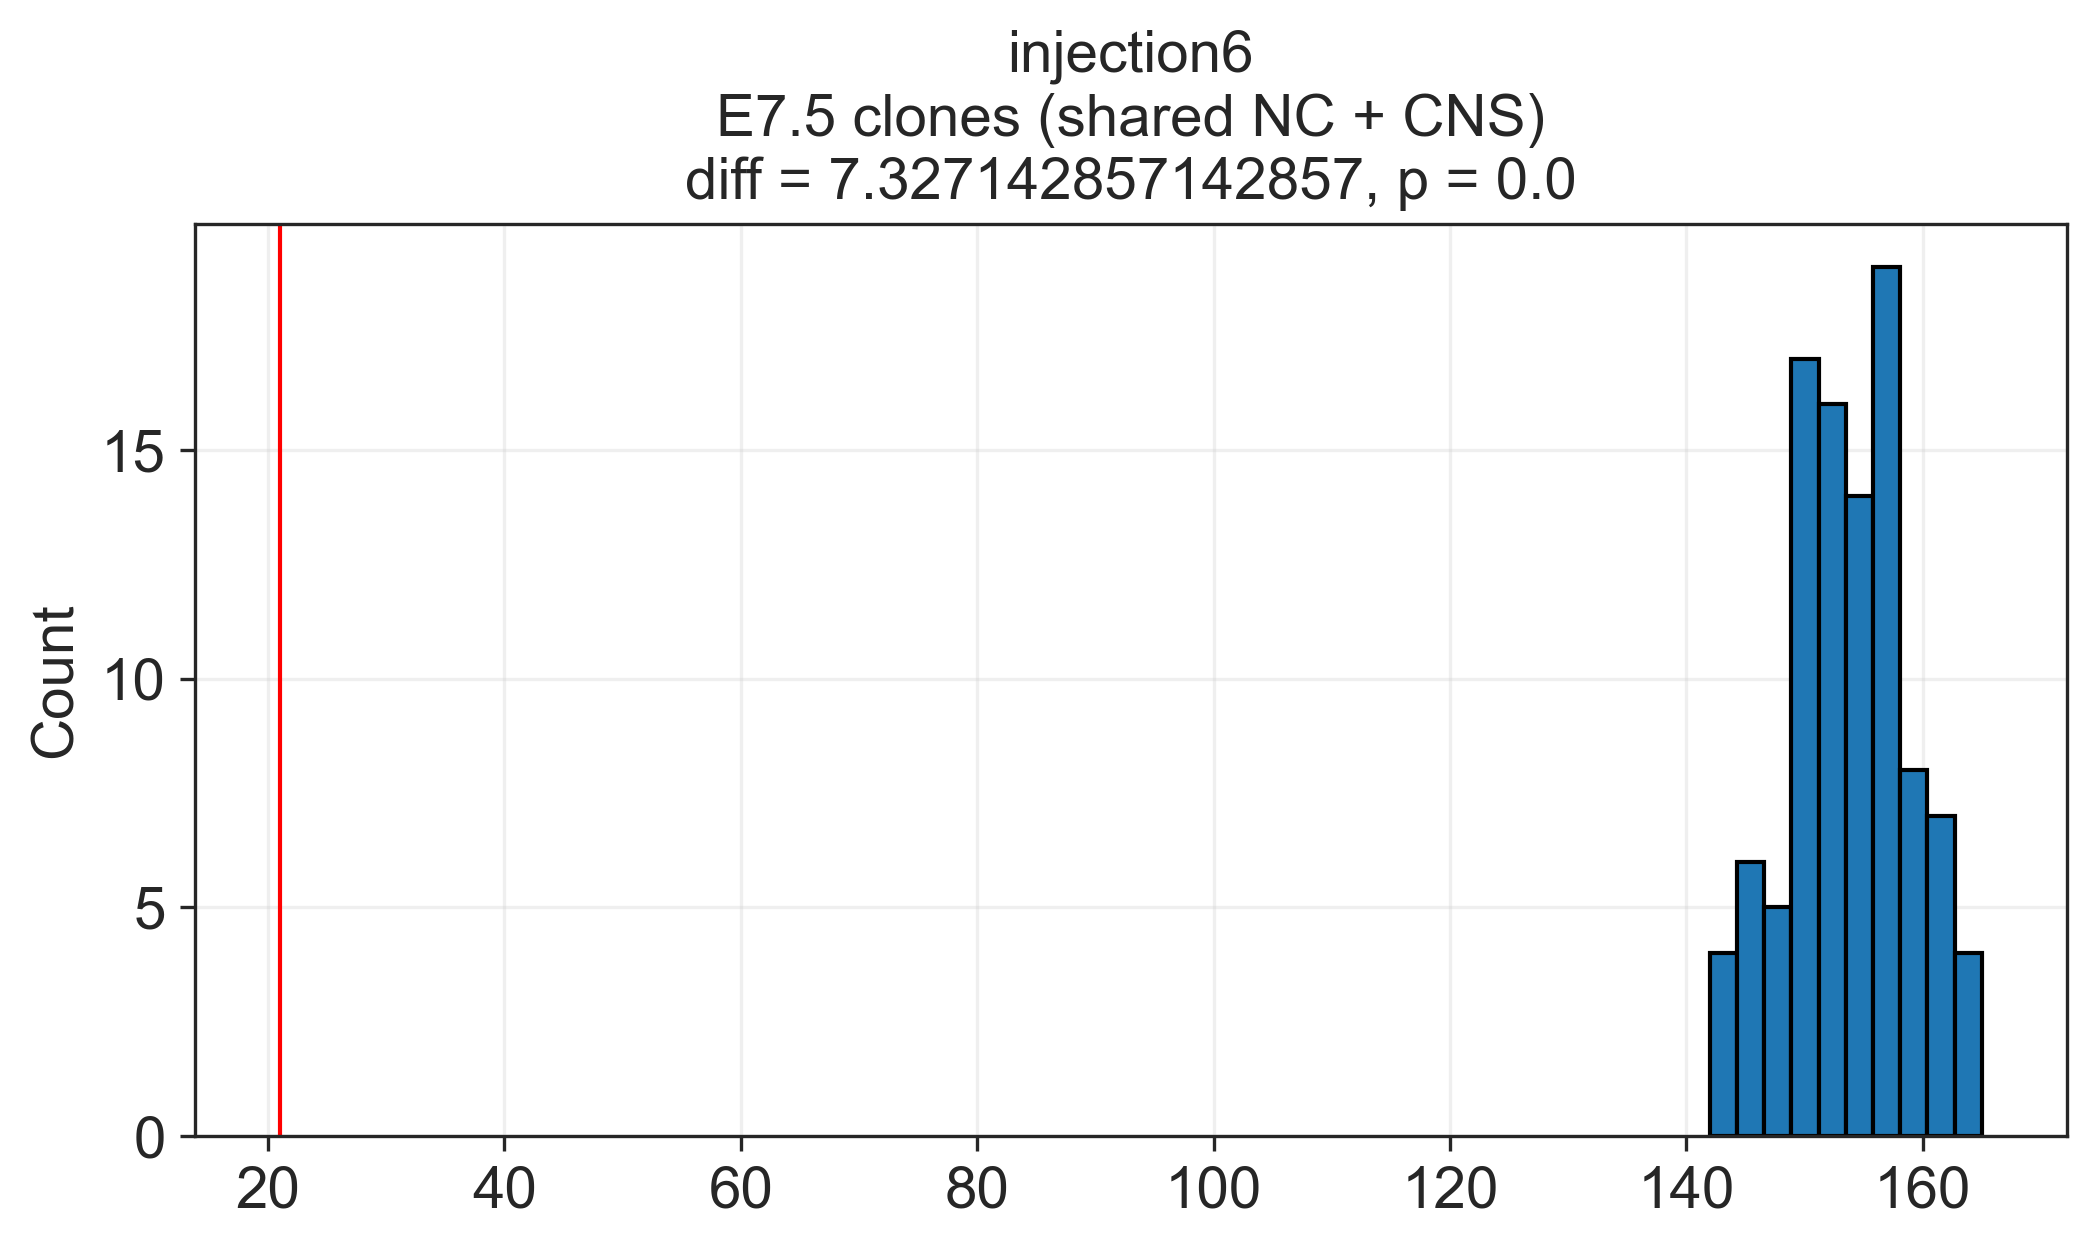

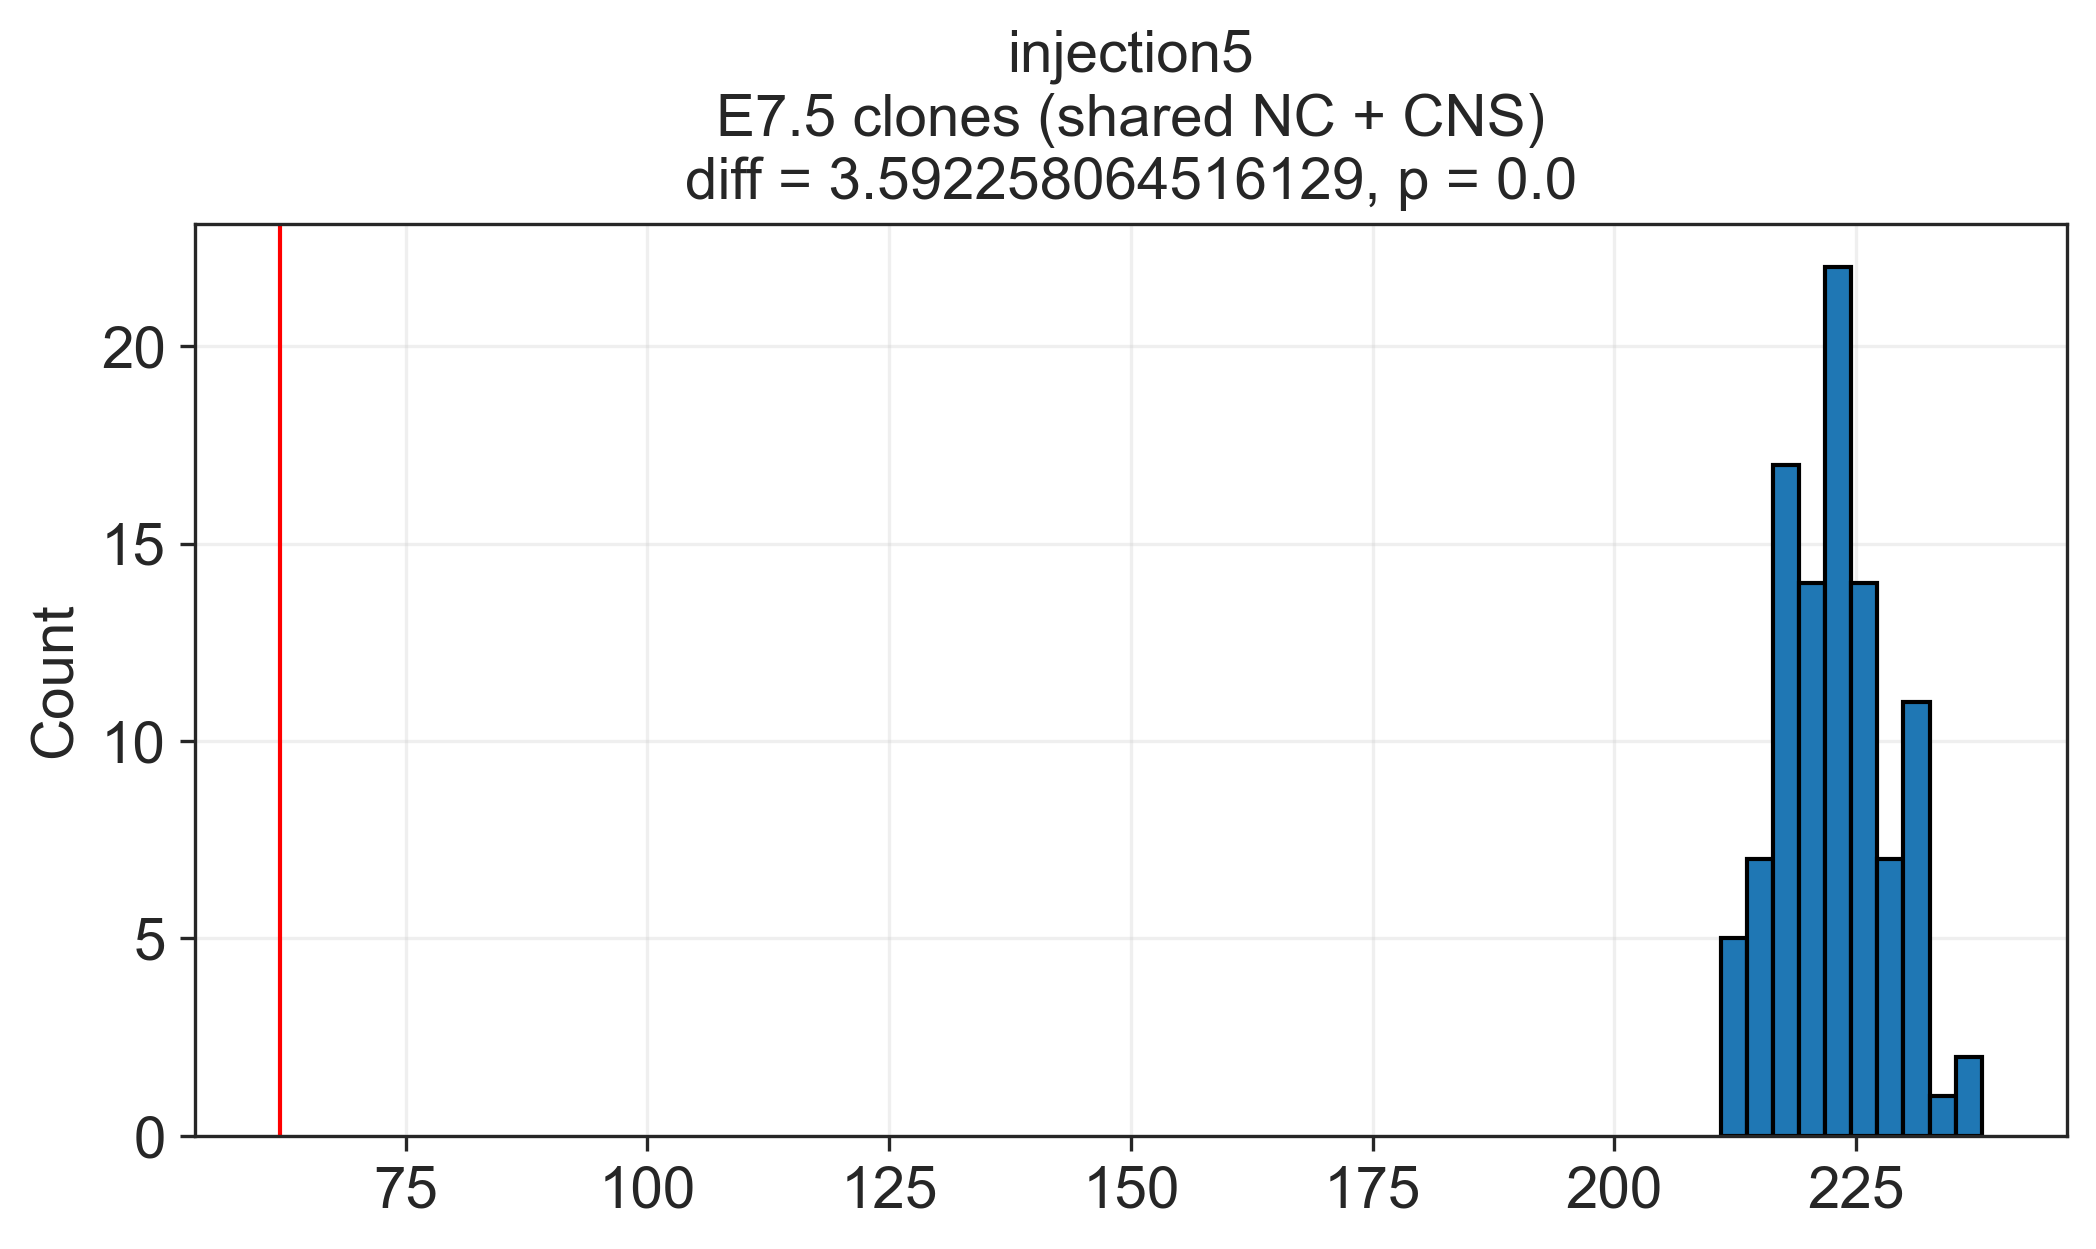

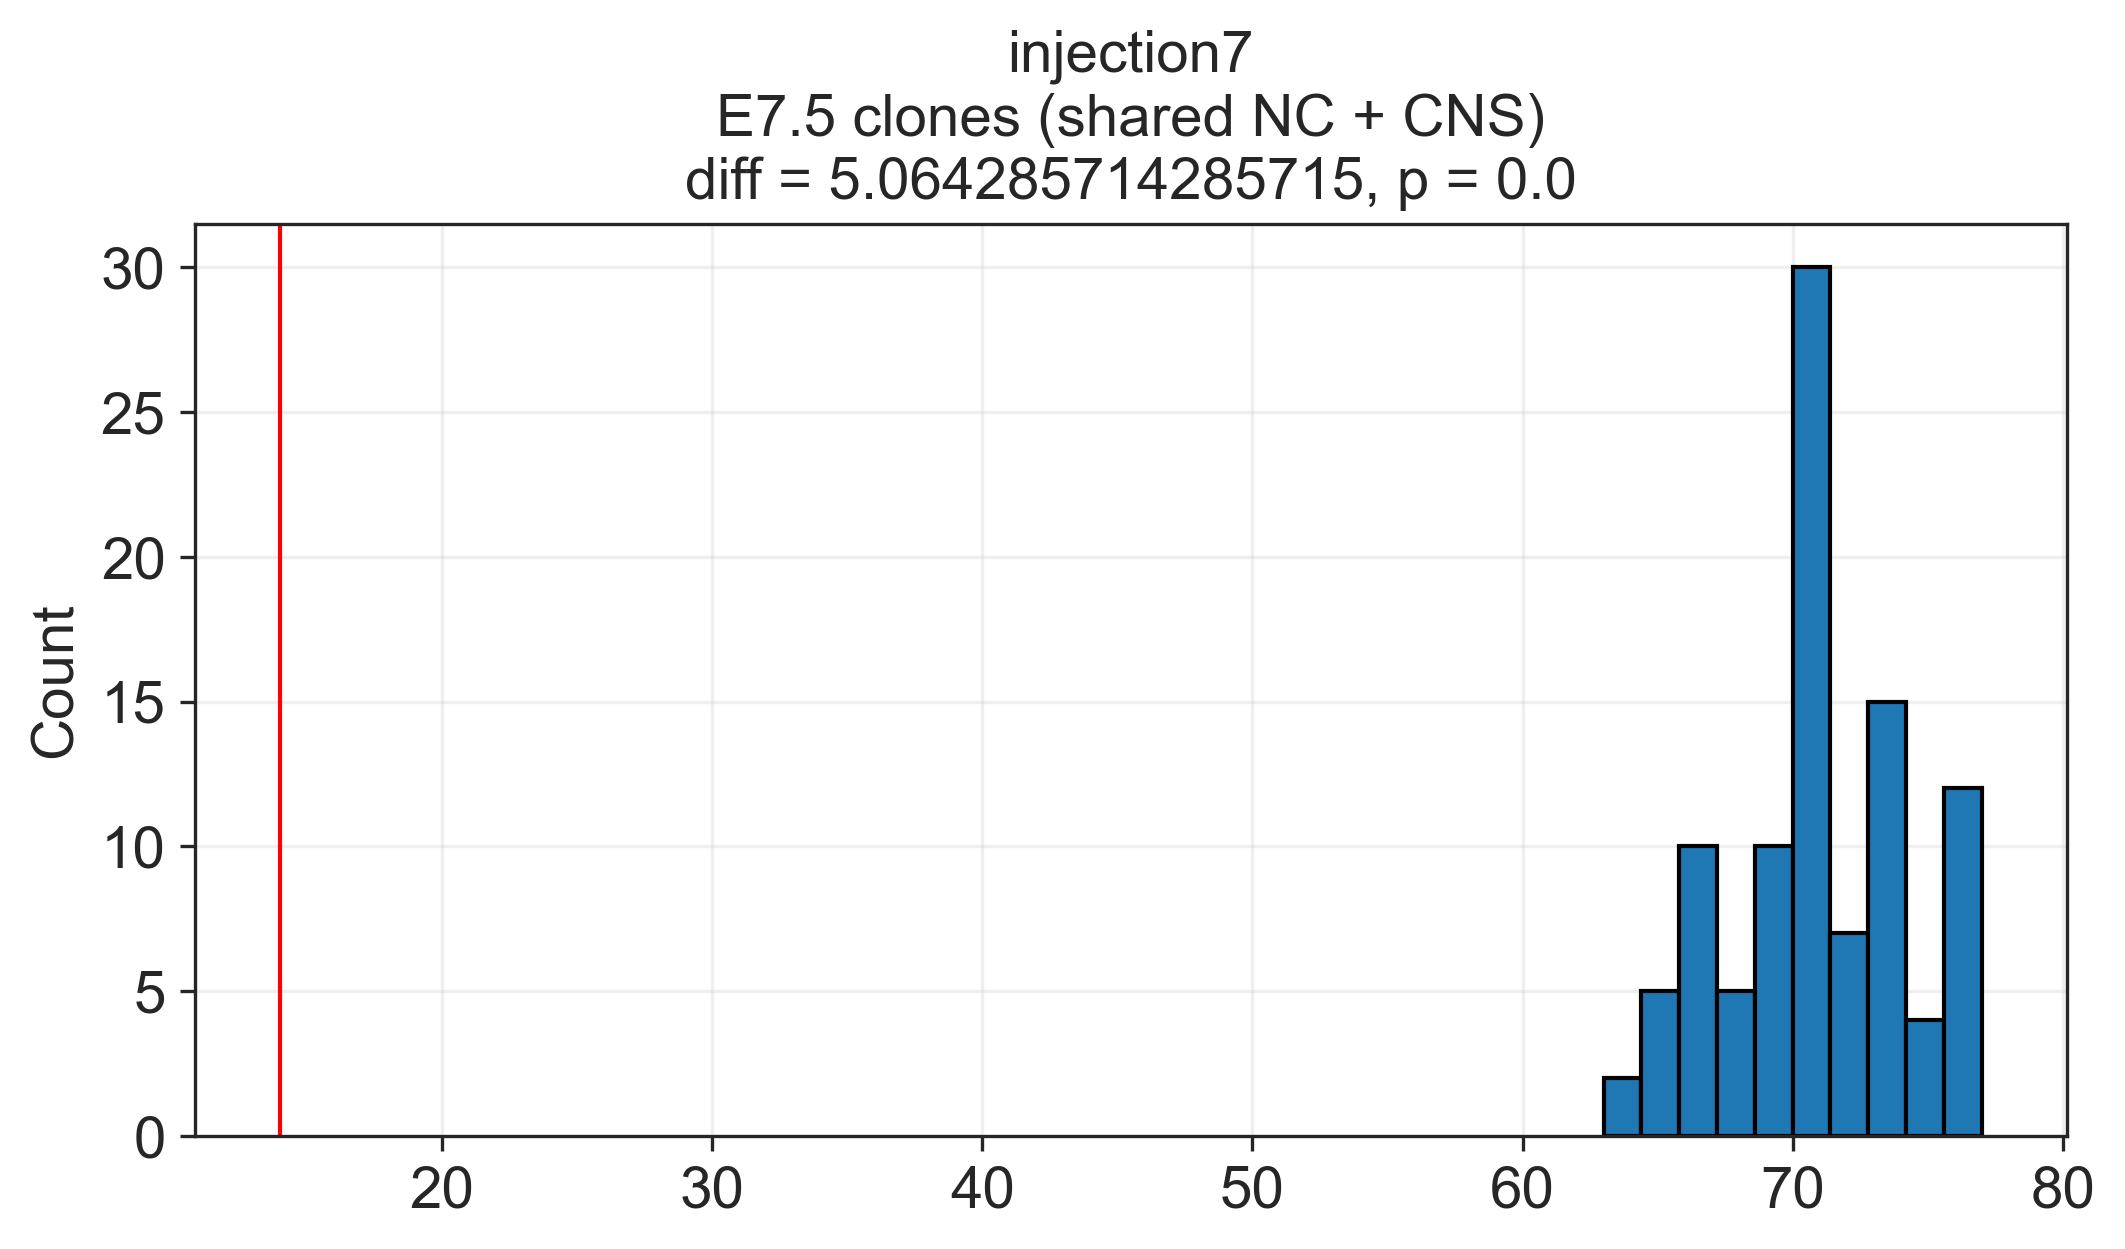

In [141]:
props_E7 = {}
for batch in set(df_E7.batch):
    E7_shared_permut = []
    E7_shared = num_shared(df_E7[df_E7.batch == batch], "E7.5:clones")
    num_permut = 100

    for i in tqdm(range(num_permut)):
        df_permut = pd.DataFrame({
            "E7.5:clones": df_E7[df_E7.batch == batch]["E7.5:clones"],
            "celltype_l1": np.random.permutation(df_E7[df_E7.batch == batch]["celltype_l1"]),
        })
        E7_shared_permut.append(num_shared(df_permut, "E7.5:clones"))
        
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.histplot(E7_shared_permut, bins=10, ax=ax, alpha=1, edgecolor="black")
    ax.set_ylim(*ax.get_ylim())
    ax.plot([E7_shared, E7_shared], [0, 1000], color="red", linewidth=1)

    E7_shared_permut = np.array(E7_shared_permut) 

    p = (E7_shared_permut < E7_shared).sum() / len(E7_shared_permut)
    diff = E7_shared_permut.mean() / E7_shared

    ax.set_title(f"{batch}\nE7.5 clones (shared NC + CNS)\ndiff = {diff}, p = {p}")
    ax.grid(alpha=0.3)
    props_E7[batch] = diff

100%|██████████| 100/100 [00:02<00:00, 44.61it/s]


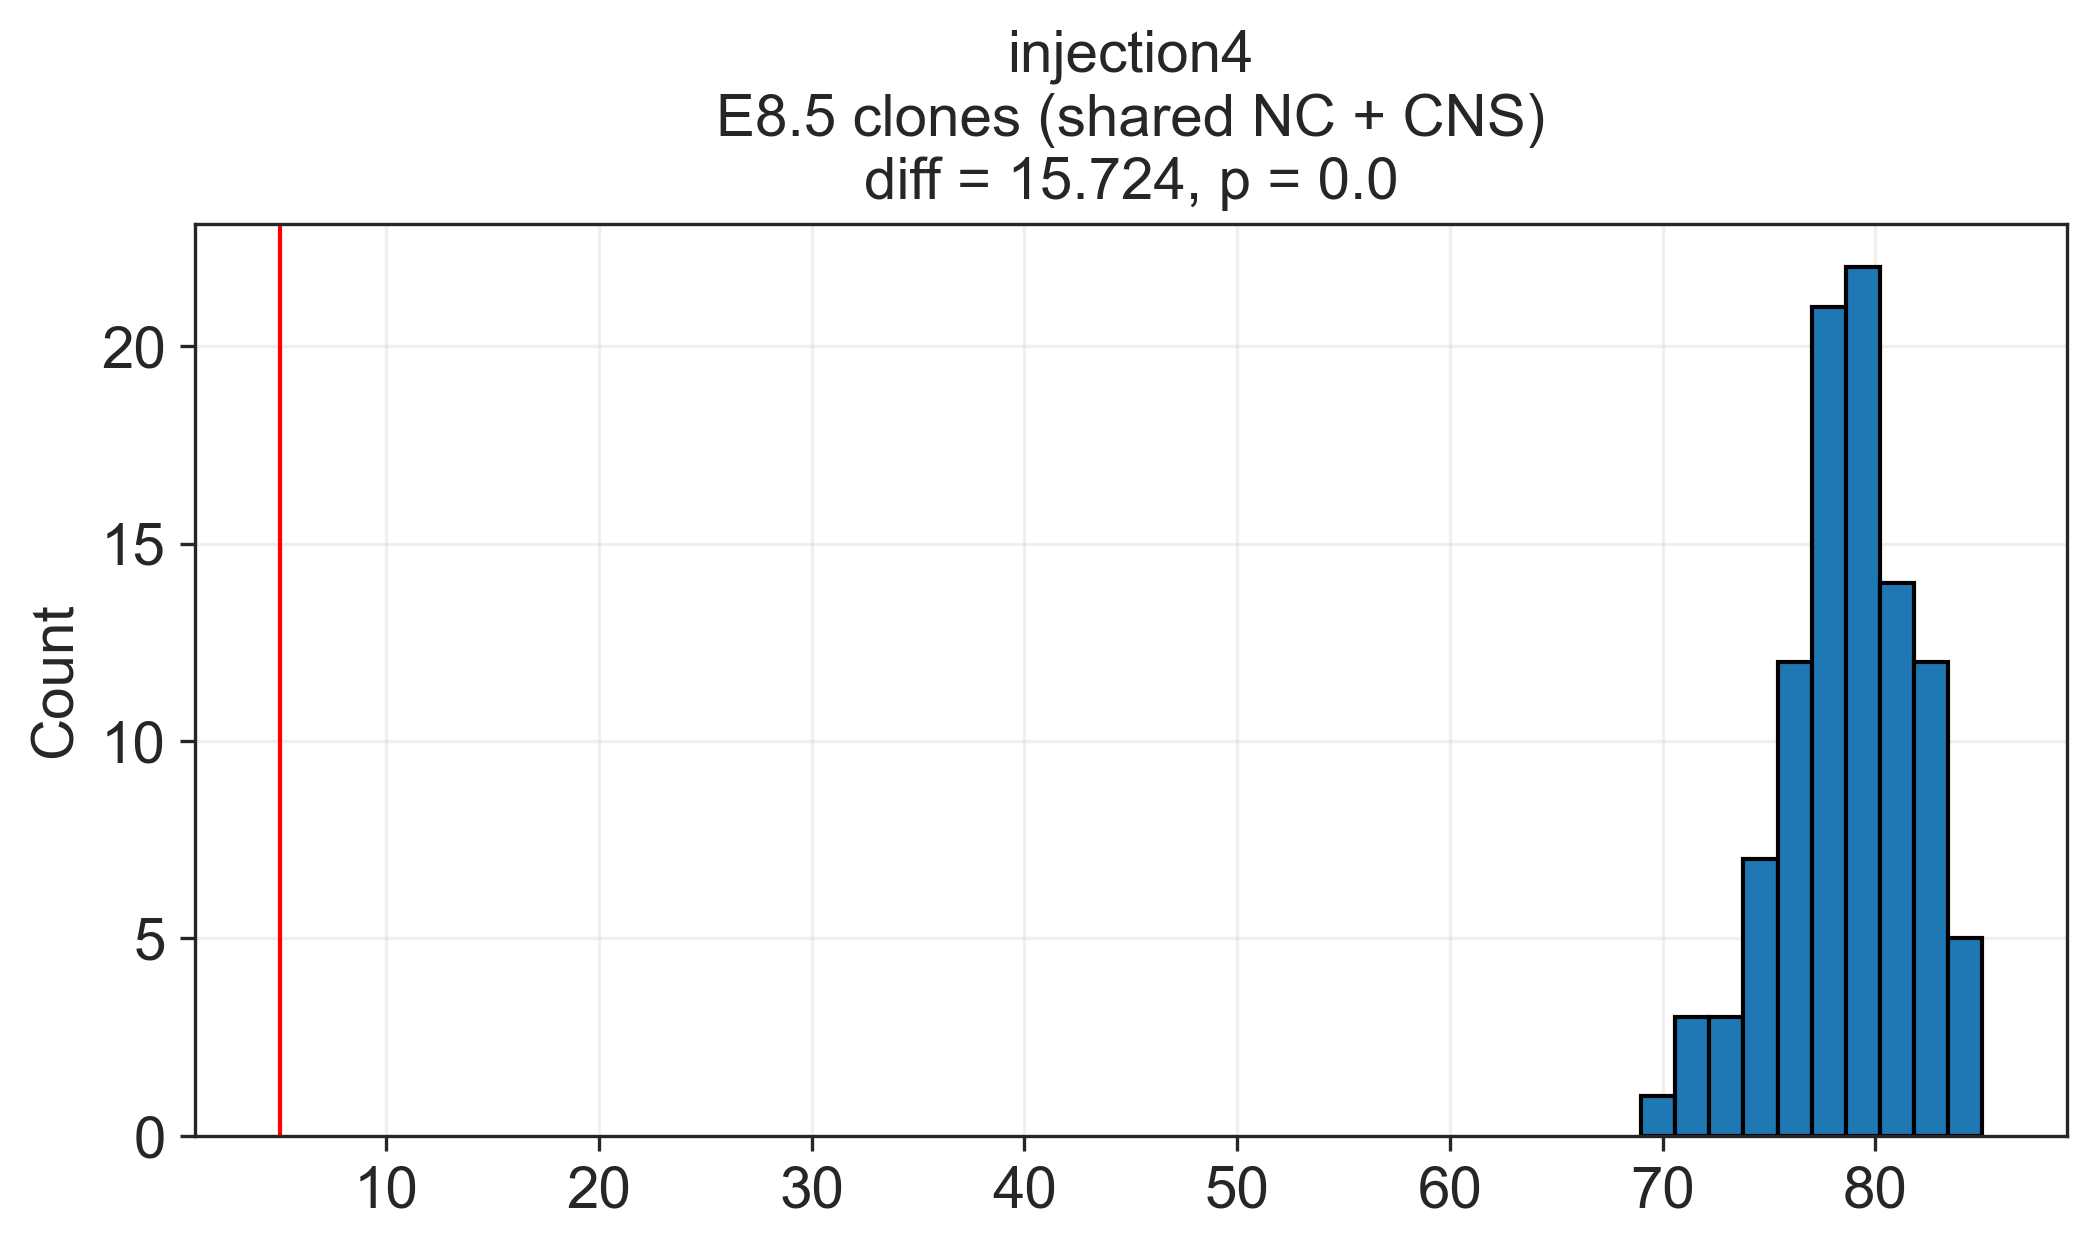

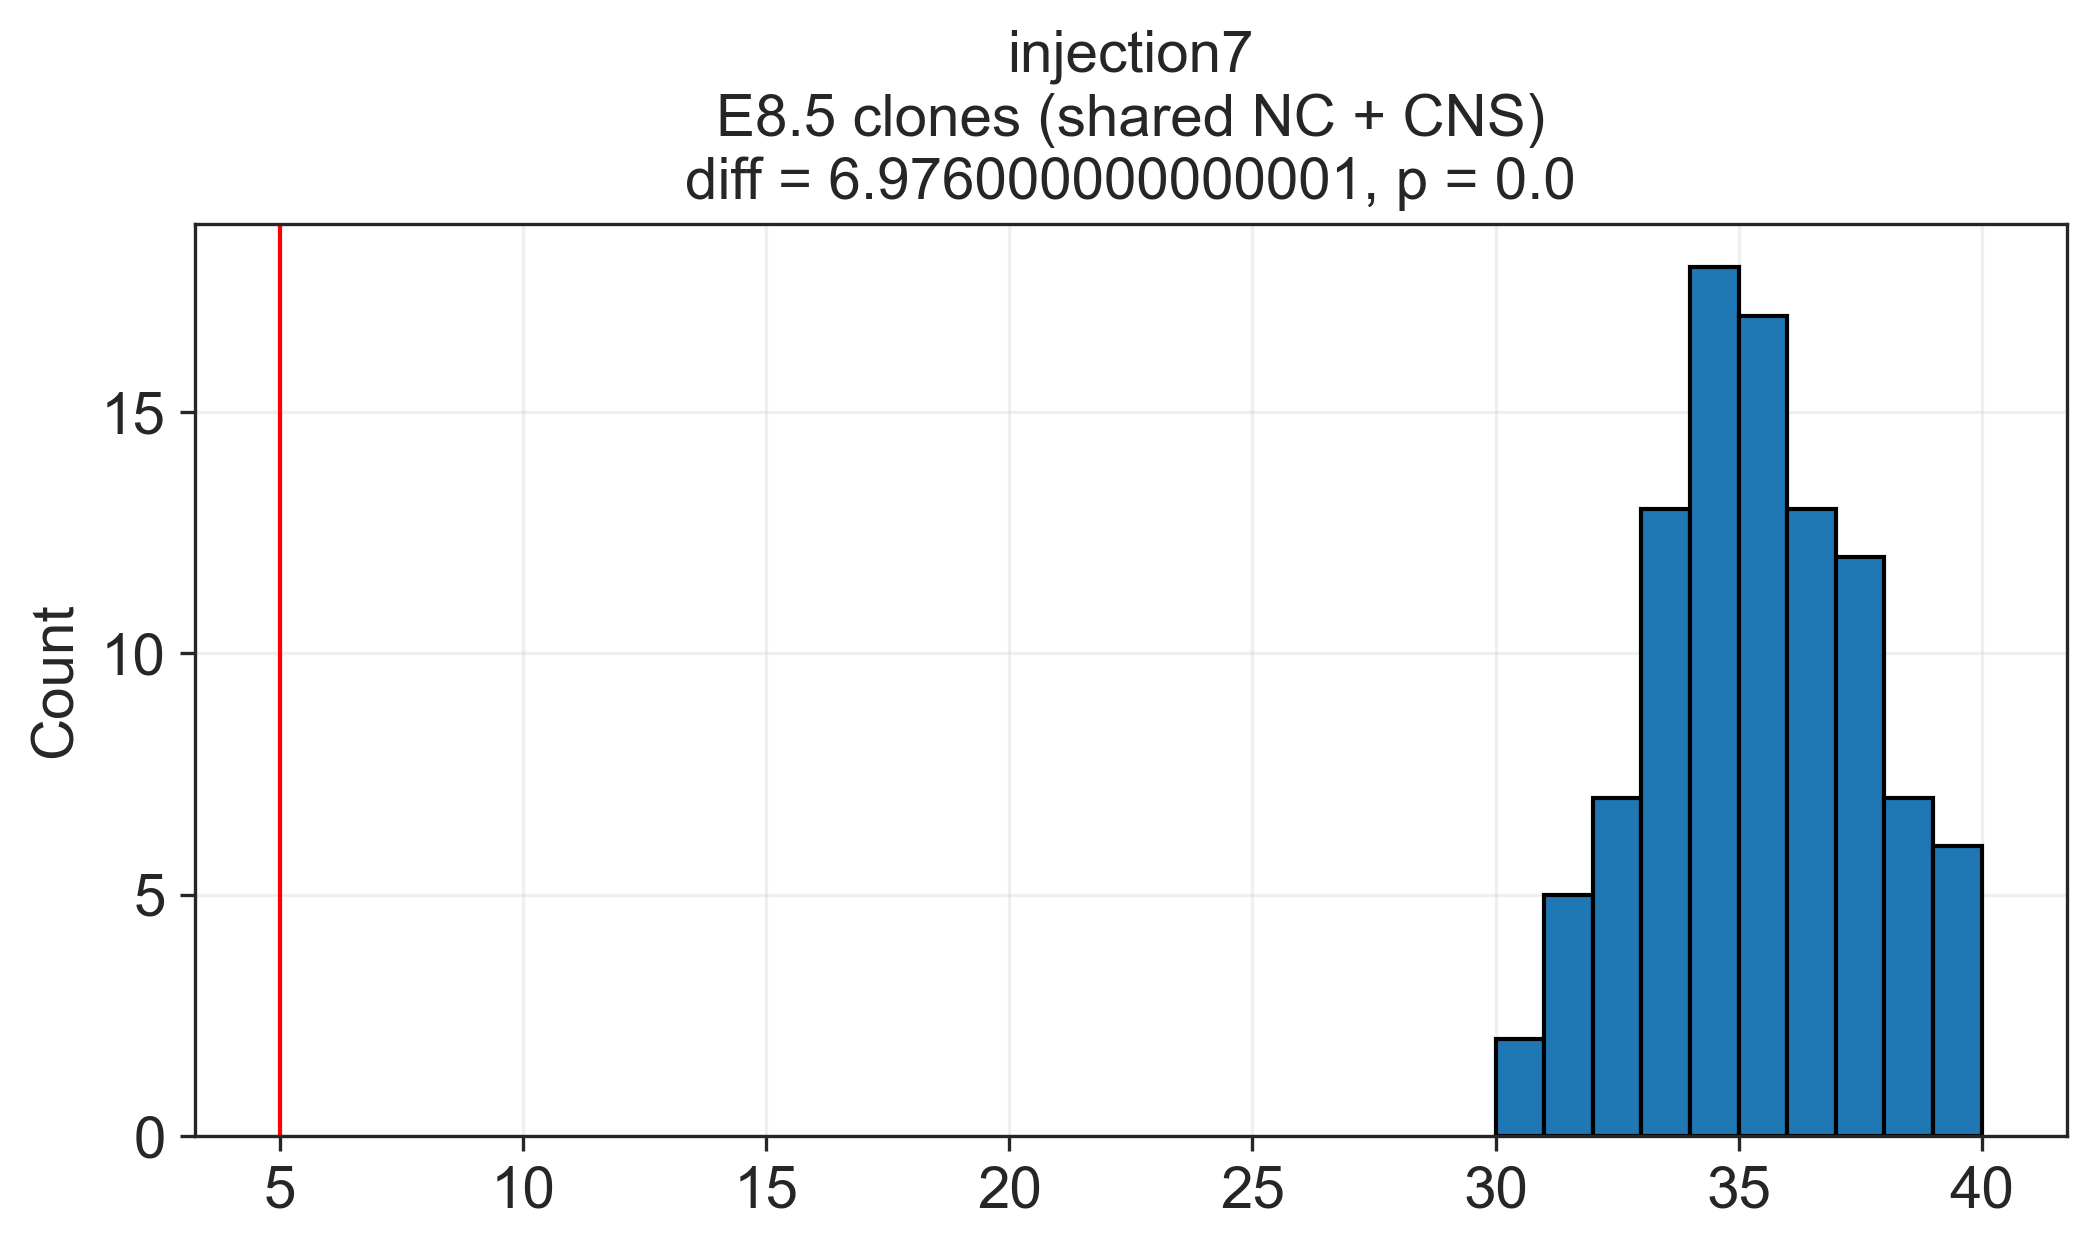

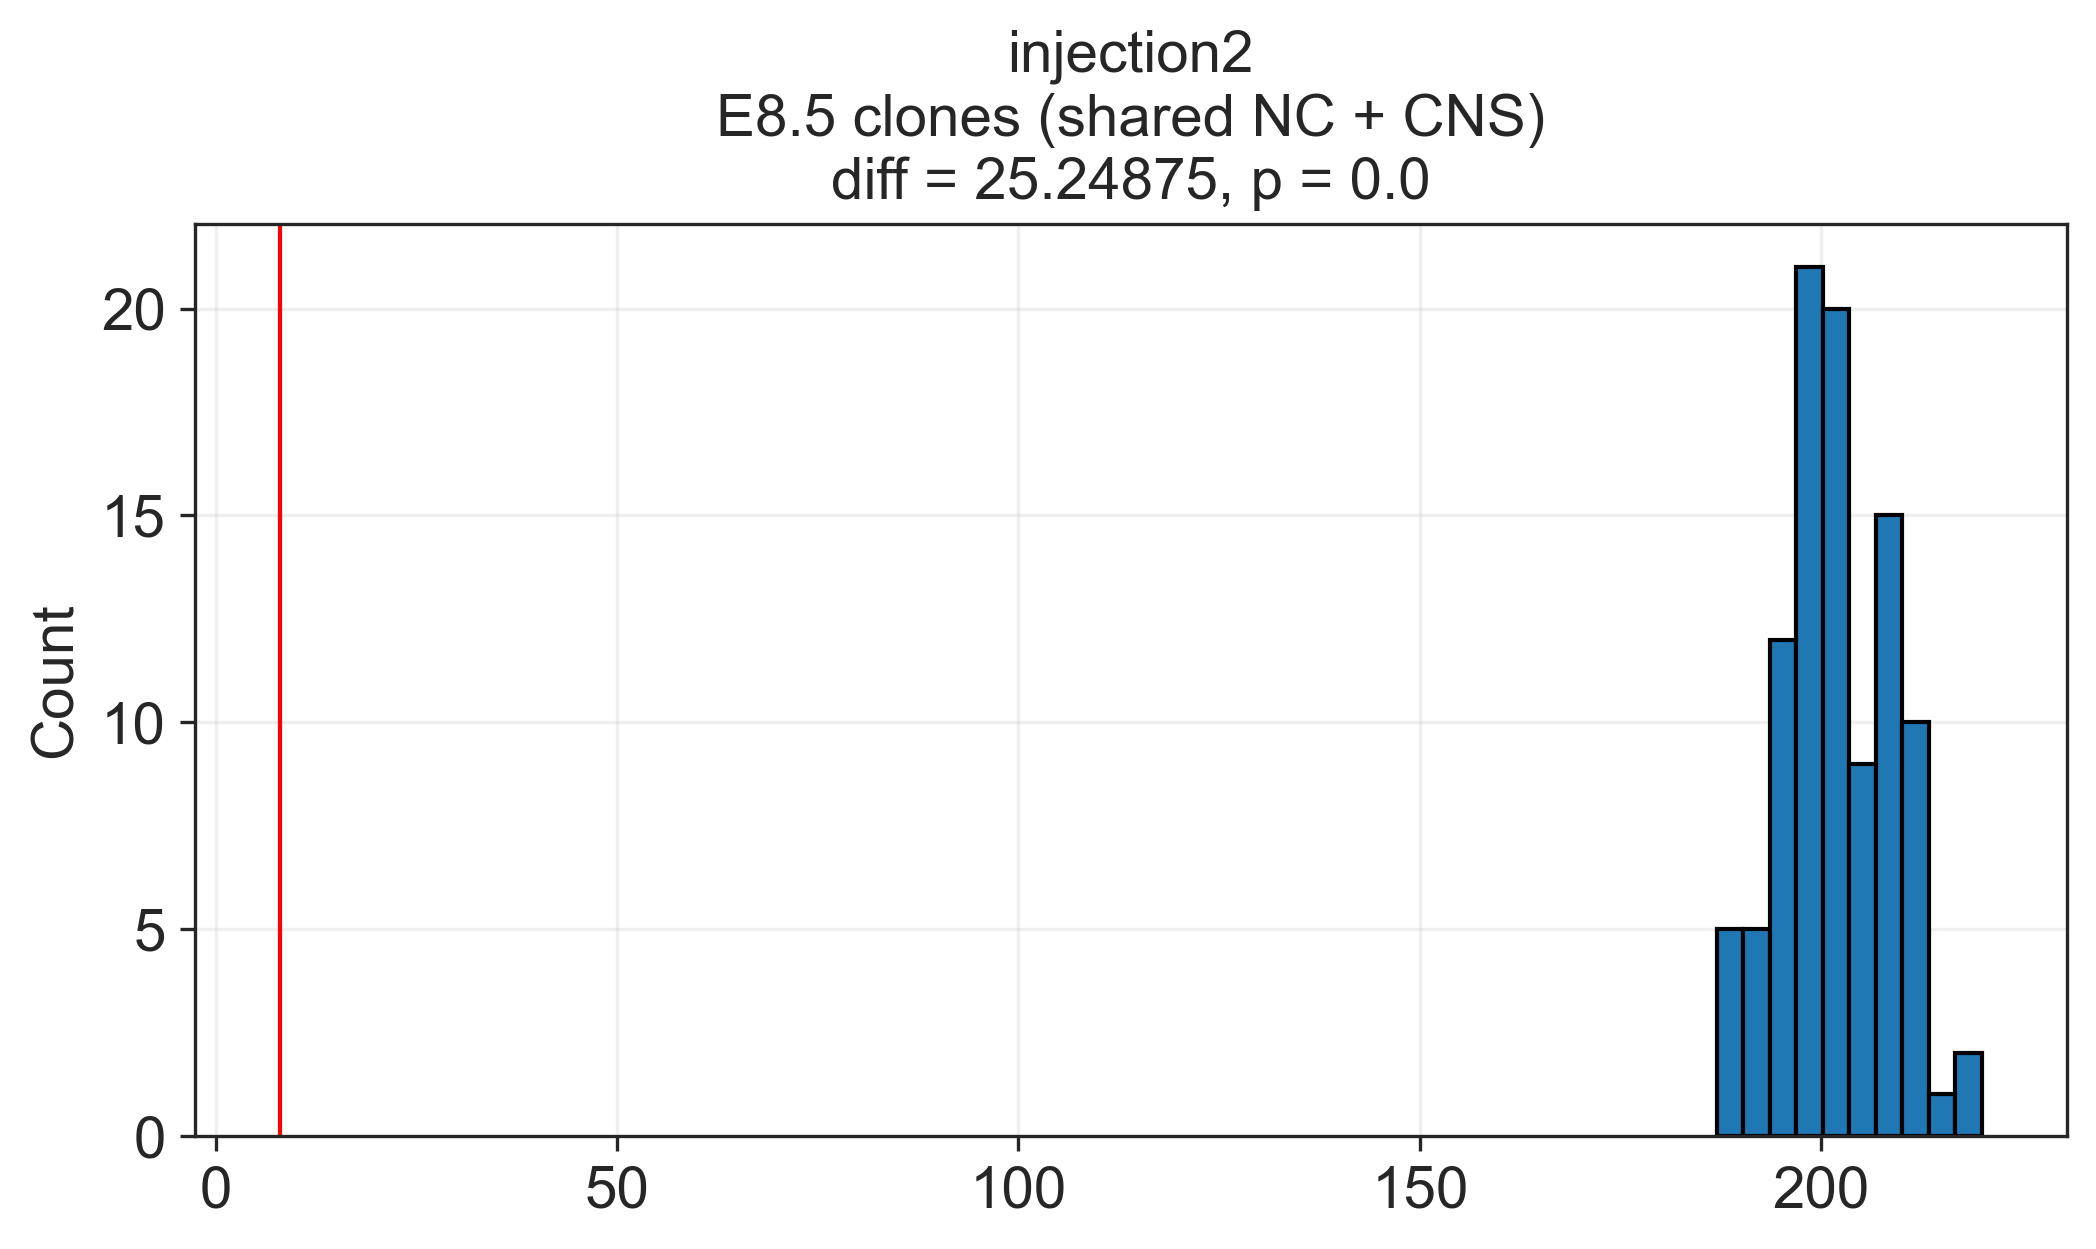

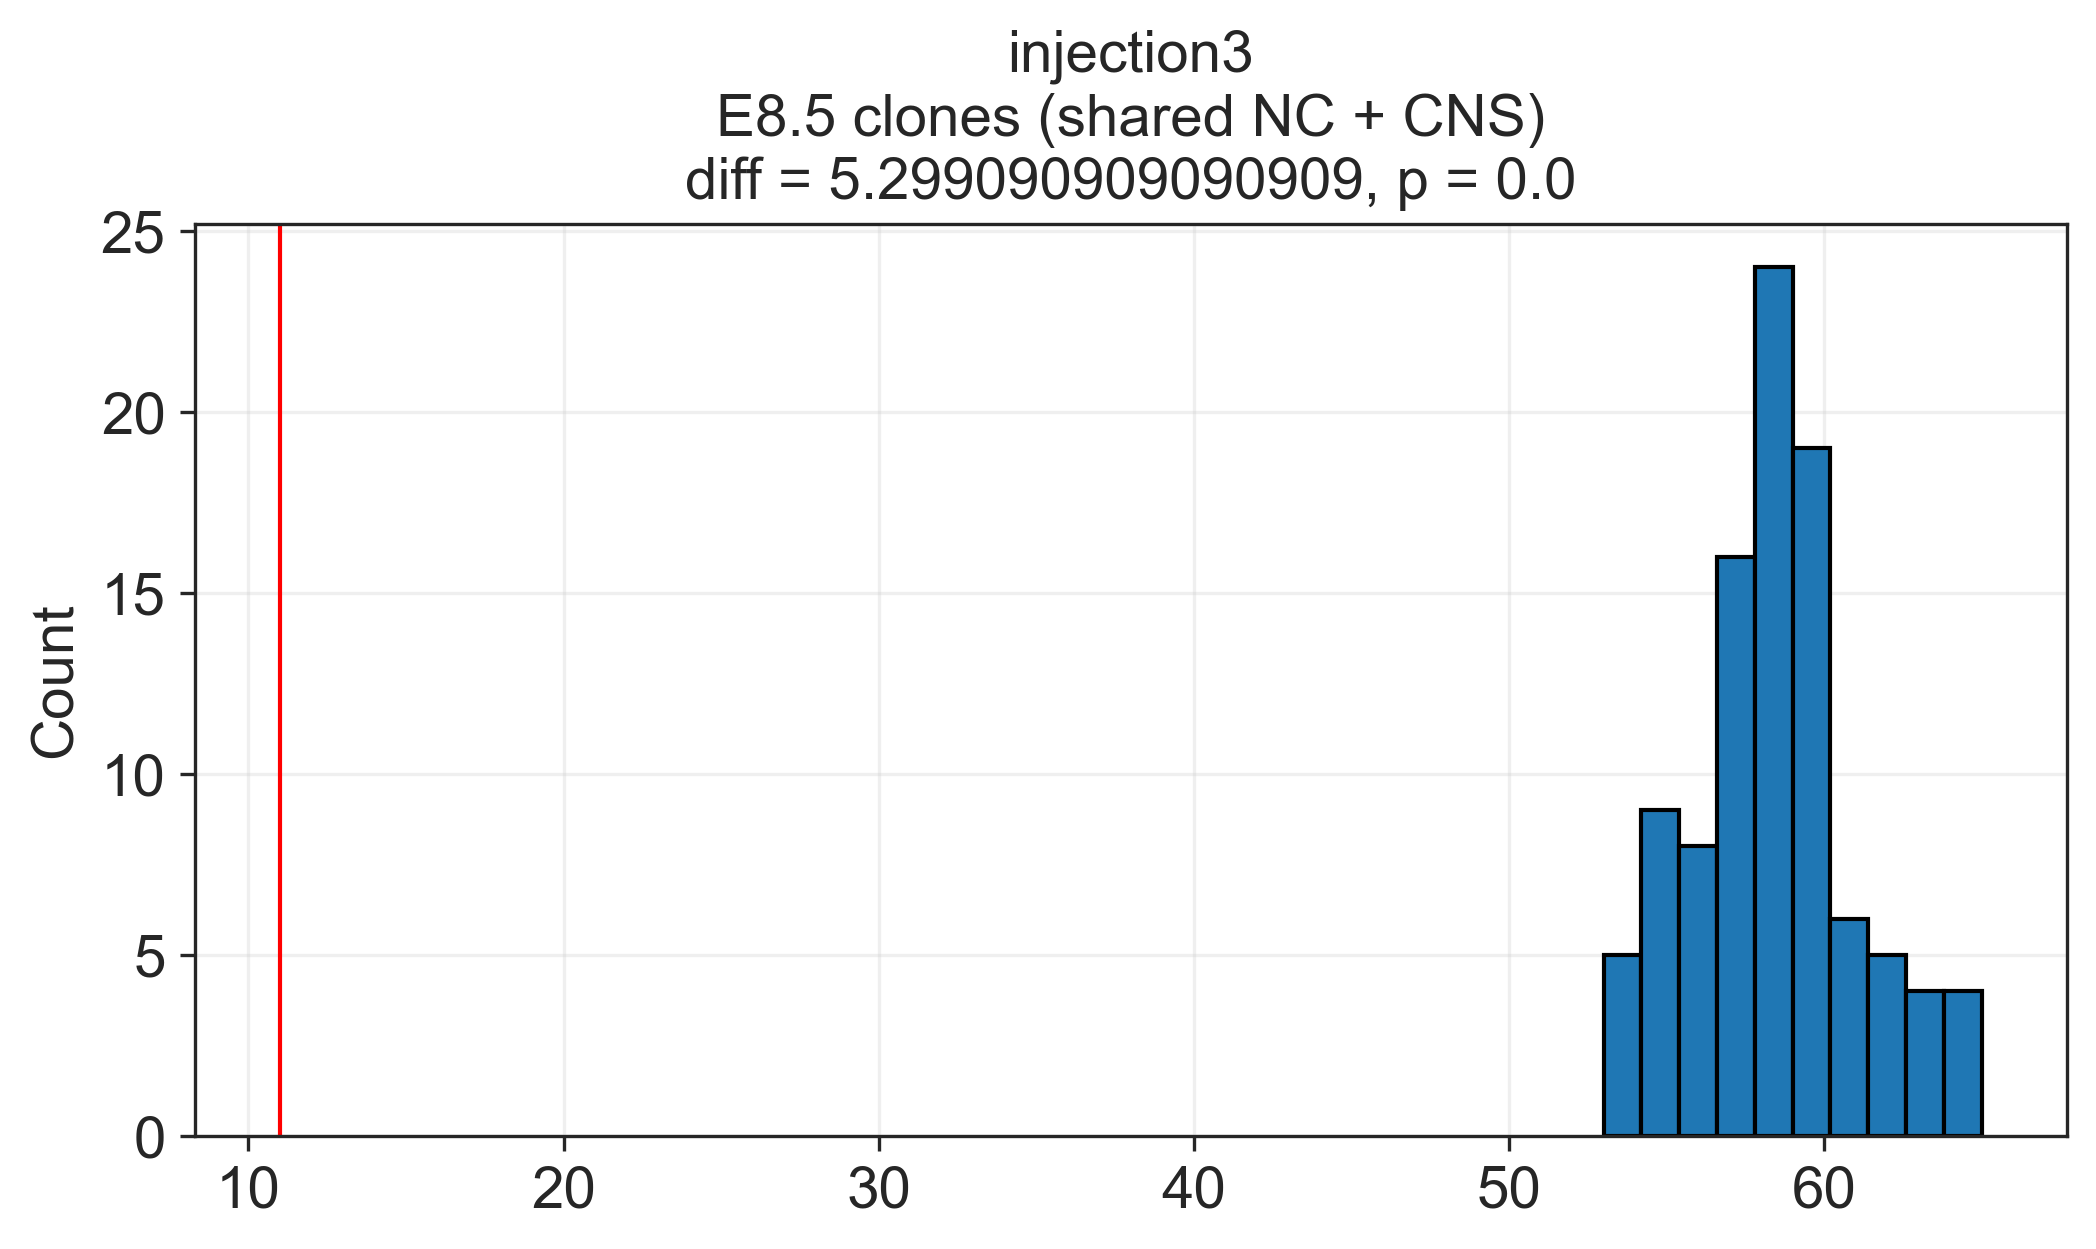

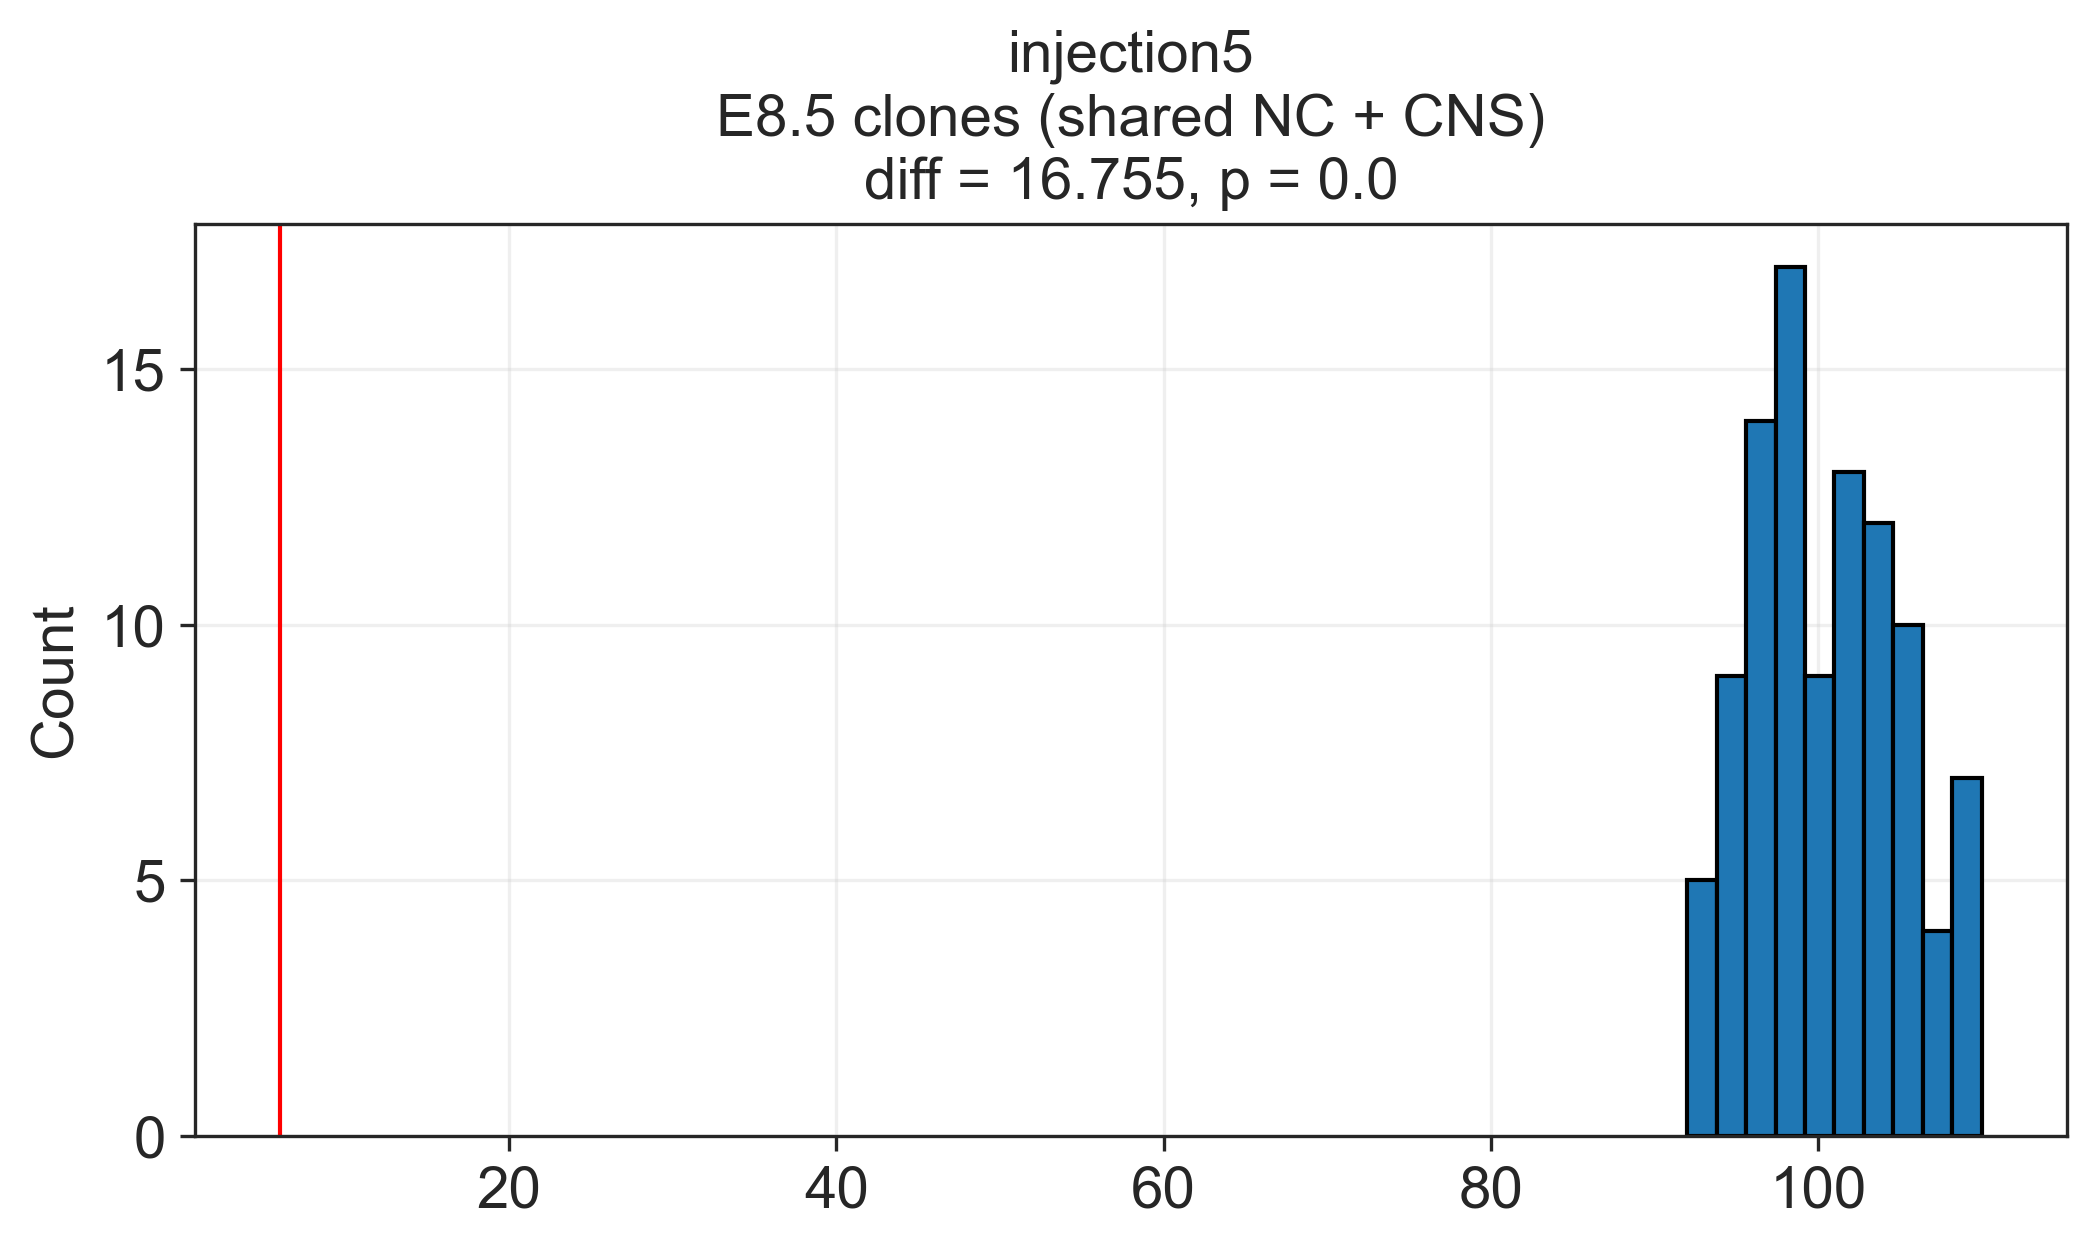

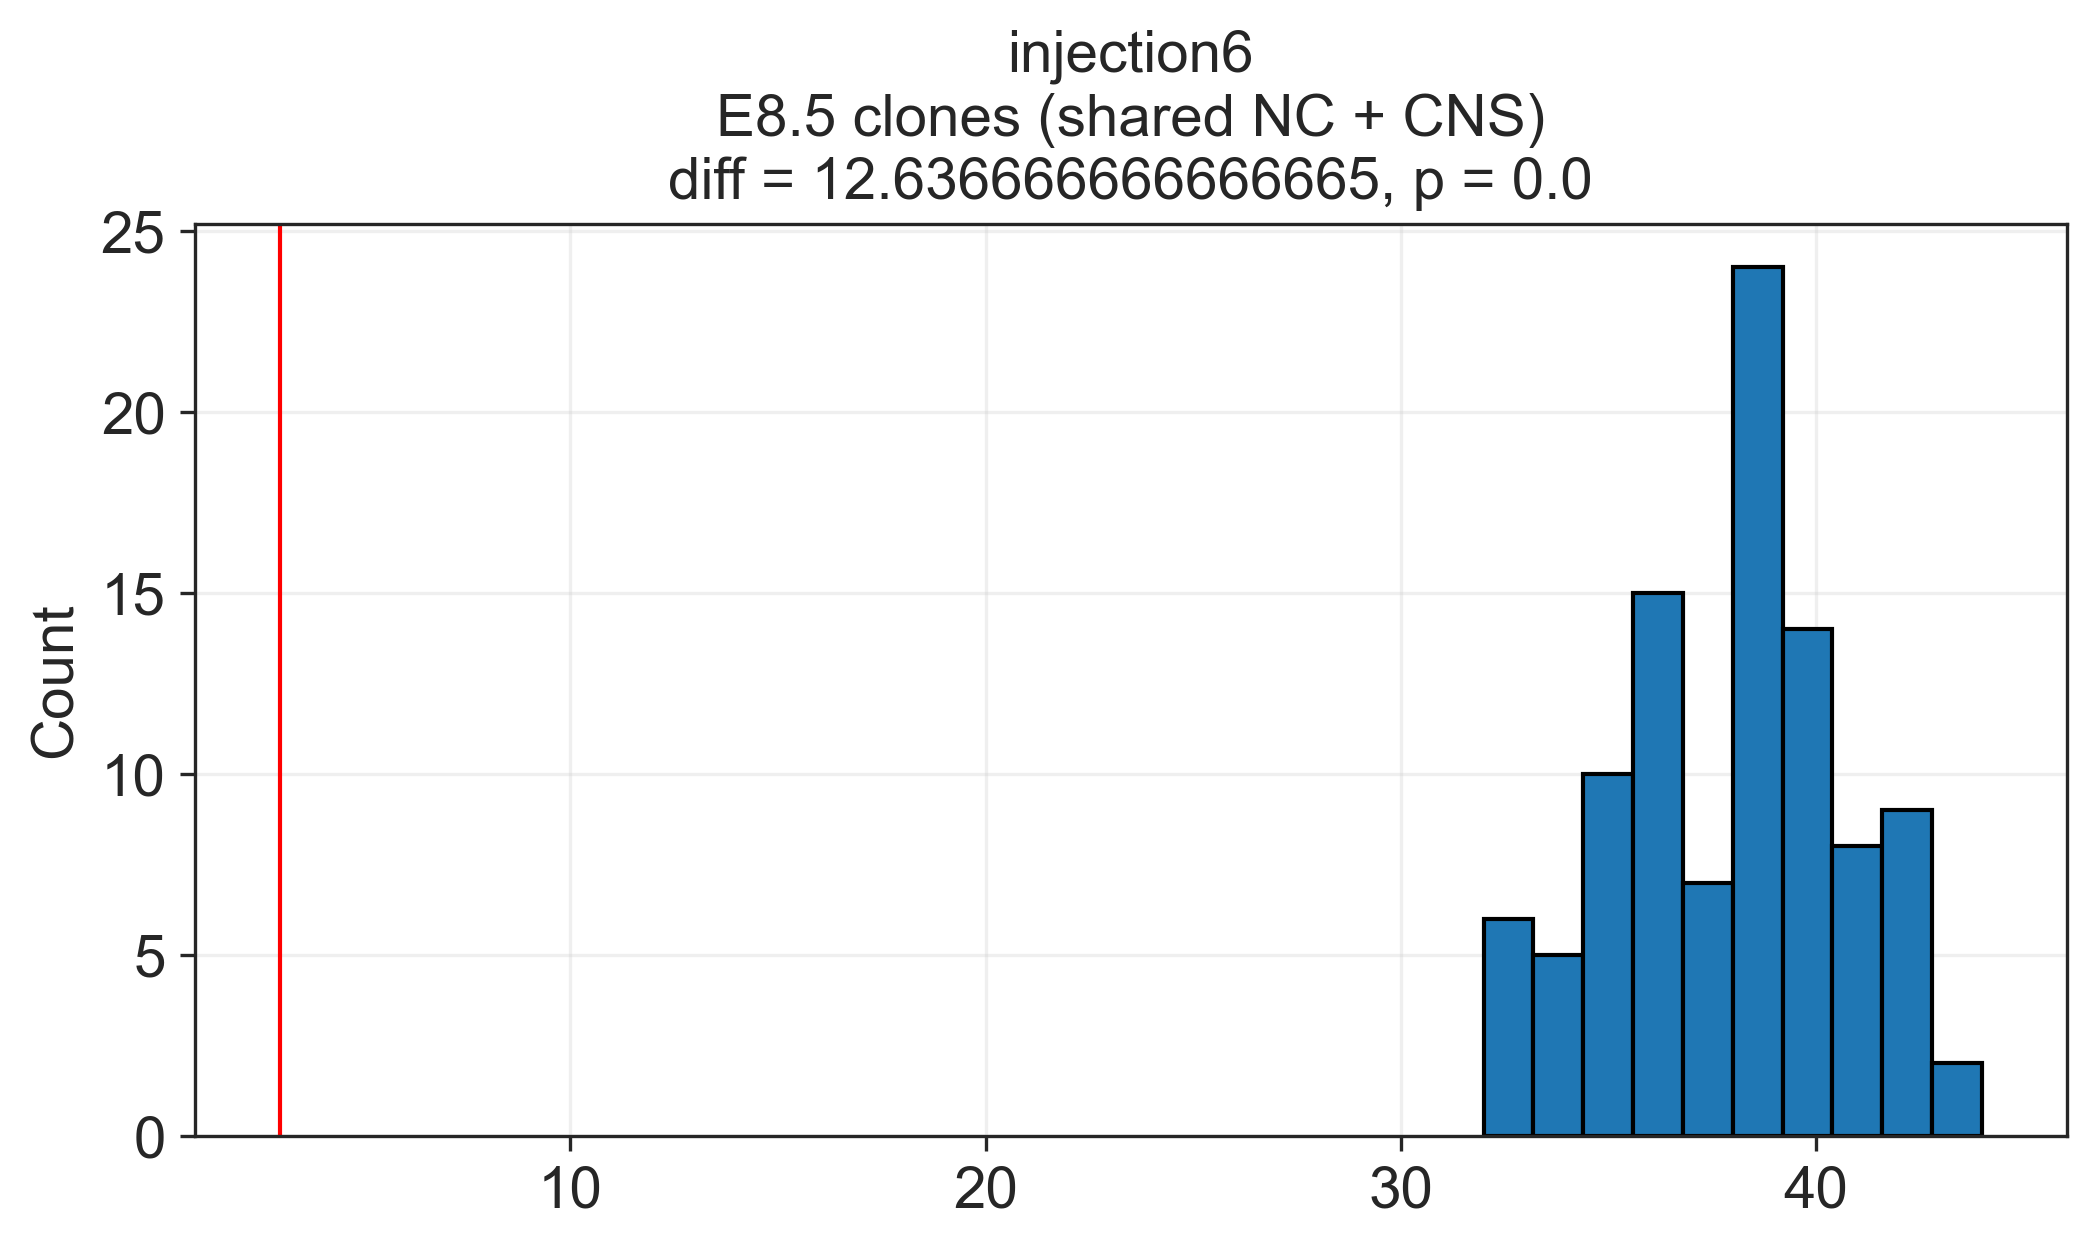

In [150]:
props_E8 = {}
for batch in set(df_E8.batch):
    E8_shared_permut = []
    E8_shared = num_shared(df_E8[df_E8.batch == batch], "E8.5:clones")
    num_permut = 100

    for i in tqdm(range(num_permut)):
        df_permut = pd.DataFrame({
            "E8.5:clones": df_E8[df_E8.batch == batch]["E8.5:clones"],
            "celltype_l1": np.random.permutation(df_E8[df_E8.batch == batch]["celltype_l1"]),
        })
        E8_shared_permut.append(num_shared(df_permut, "E8.5:clones"))
        
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.histplot(E8_shared_permut, bins=10, ax=ax, alpha=1, edgecolor="black")
    ax.set_ylim(*ax.get_ylim())
    ax.plot([E8_shared, E8_shared], [0, 1000], color="red", linewidth=1)

    E8_shared_permut = np.array(E8_shared_permut) 

    p = (E8_shared_permut < E8_shared).sum() / len(E8_shared_permut)
    diff = E8_shared_permut.mean() / E8_shared

    ax.set_title(f"{batch}\nE8.5 clones (shared NC + CNS)\ndiff = {diff}, p = {p}")
    ax.grid(alpha=0.3)
    props_E8[batch] = diff

In [145]:
props_E8

{'injection4': 15.613999999999999,
 'injection7': 6.946,
 'injection2': 25.0625,
 'injection3': 5.307272727272728,
 'injection5': 16.87,
 'injection6': 12.563333333333333}

In [146]:
props_E7

{'injection6': 7.327142857142857,
 'injection5': 3.592258064516129,
 'injection7': 5.064285714285715}

In [147]:
12.6 / 7.3

1.726027397260274

In [148]:
16.87 / 3.59

4.6991643454039

In [151]:
6.9 / 5

1.3800000000000001

In [89]:
E7_shared_permut = []
E7_shared = num_shared(df_E7, "E7.5:clones")
num_permut = 1000

for i in tqdm(range(num_permut)):
    df_permut = pd.DataFrame({
        "E7.5:clones": df_E7["E7.5:clones"],
        "celltype_l1": np.random.permutation(df_E7["celltype_l1"]),
    })
    E7_shared_permut.append(num_shared(df_permut, "E7.5:clones"))

100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]


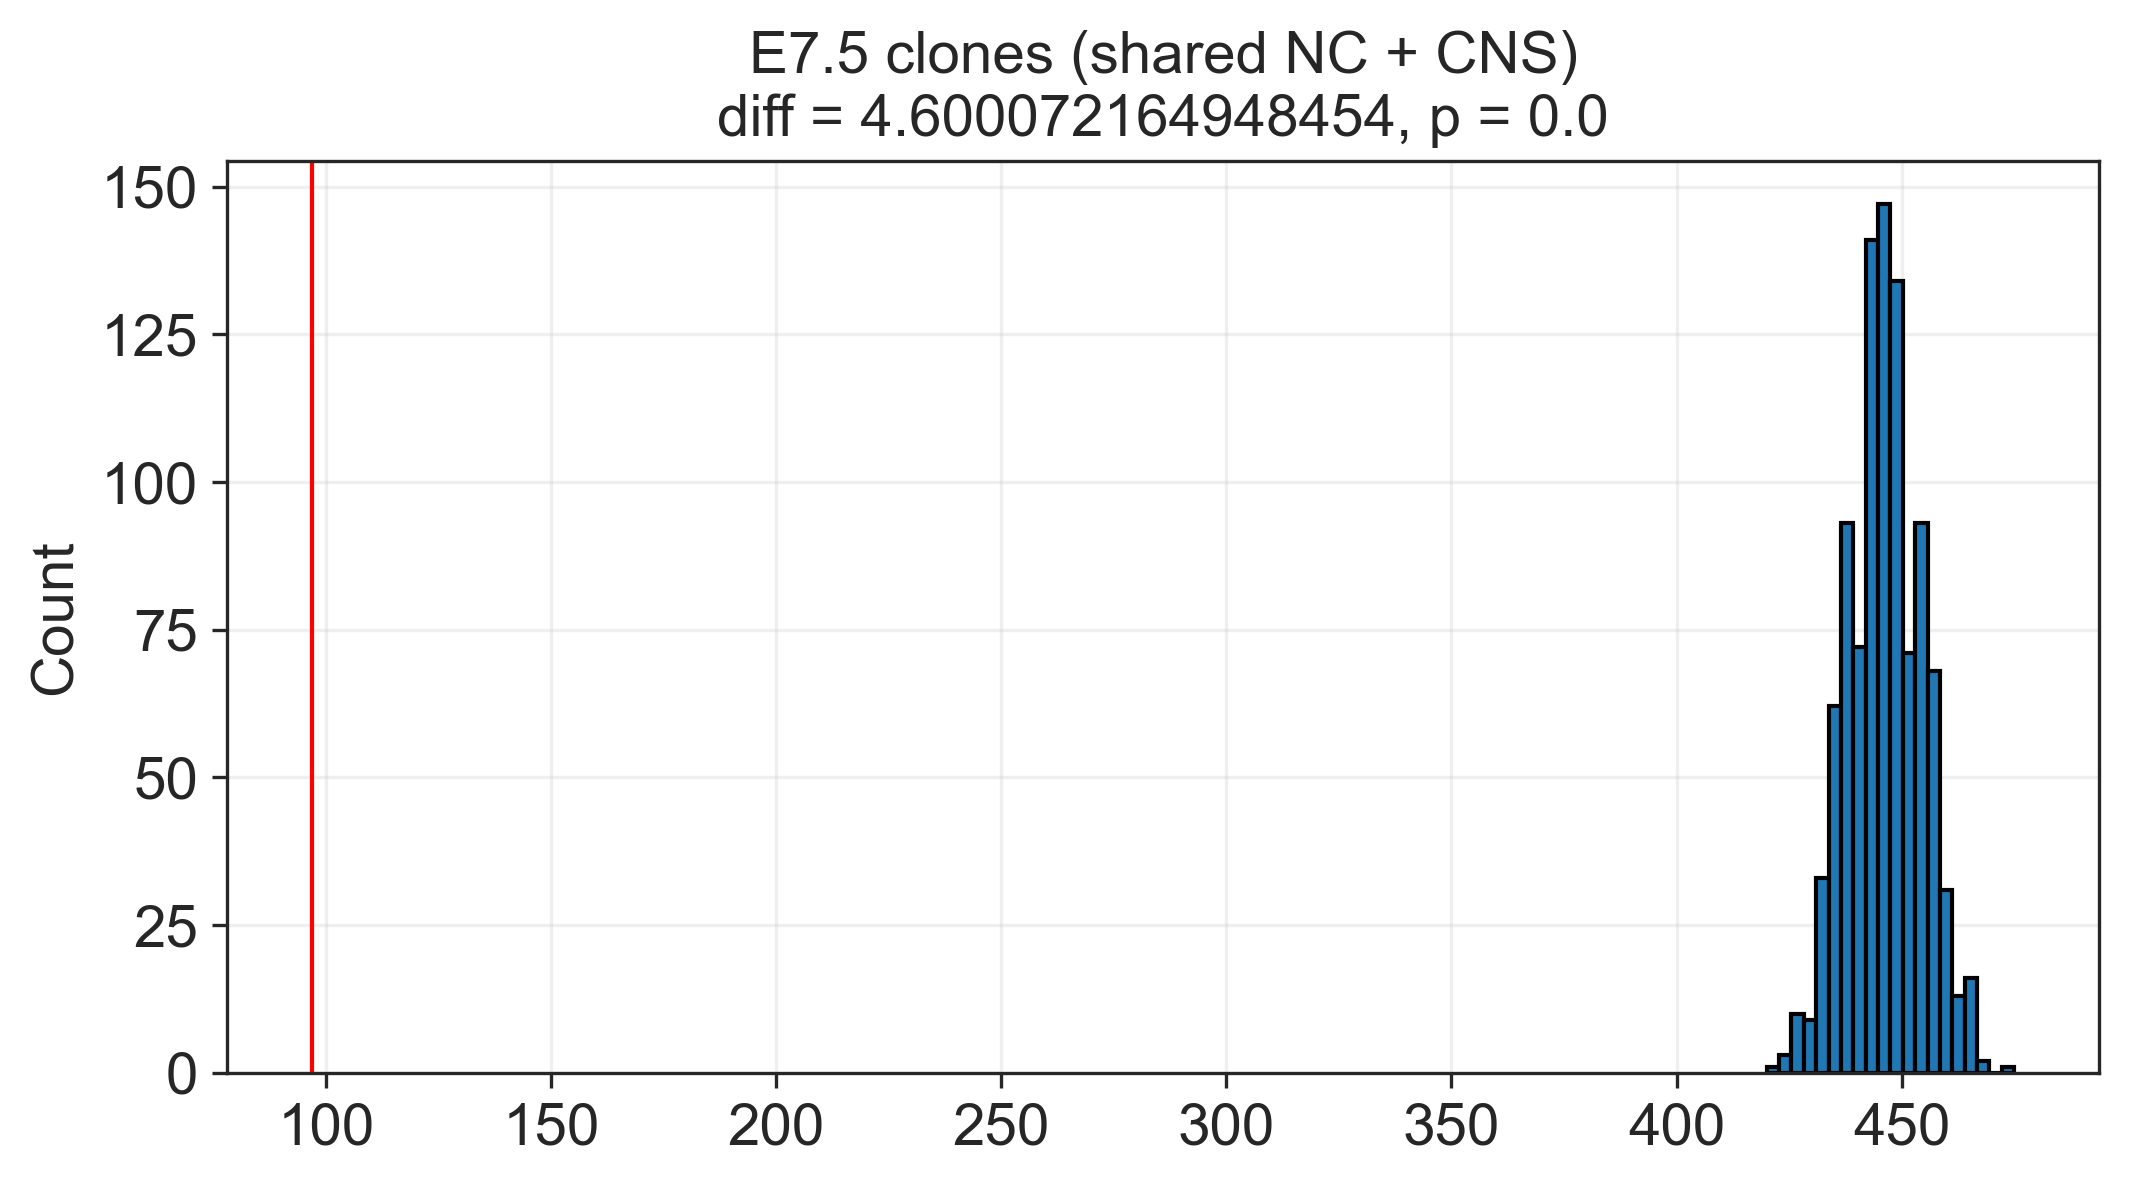

In [111]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(E7_shared_permut, bins=20, ax=ax, alpha=1, edgecolor="black")
ax.set_ylim(*ax.get_ylim())
ax.plot([E7_shared, E7_shared], [0, 1000], color="red", linewidth=1)

E7_shared_permut = np.array(E7_shared_permut) 

p = (E7_shared_permut < E7_shared).sum() / len(E7_shared_permut)
diff = E7_shared_permut.mean() / E7_shared

ax.set_title(f"E7.5 clones (shared NC + CNS)\ndiff = {diff}, p = {p}")
ax.grid(alpha=0.3)

In [93]:
from tqdm import tqdm

E8_shared_permut = []
E8_shared = num_shared(df_E8, "E8.5:clones")
num_permut = 1000

for i in tqdm(range(num_permut)):
    df_permut = pd.DataFrame({
        "E8.5:clones": df_E8["E8.5:clones"],
        "celltype_l1": np.random.permutation(df_E8["celltype_l1"]),
    })
    E8_shared_permut.append(num_shared(df_permut, "E8.5:clones"))

100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


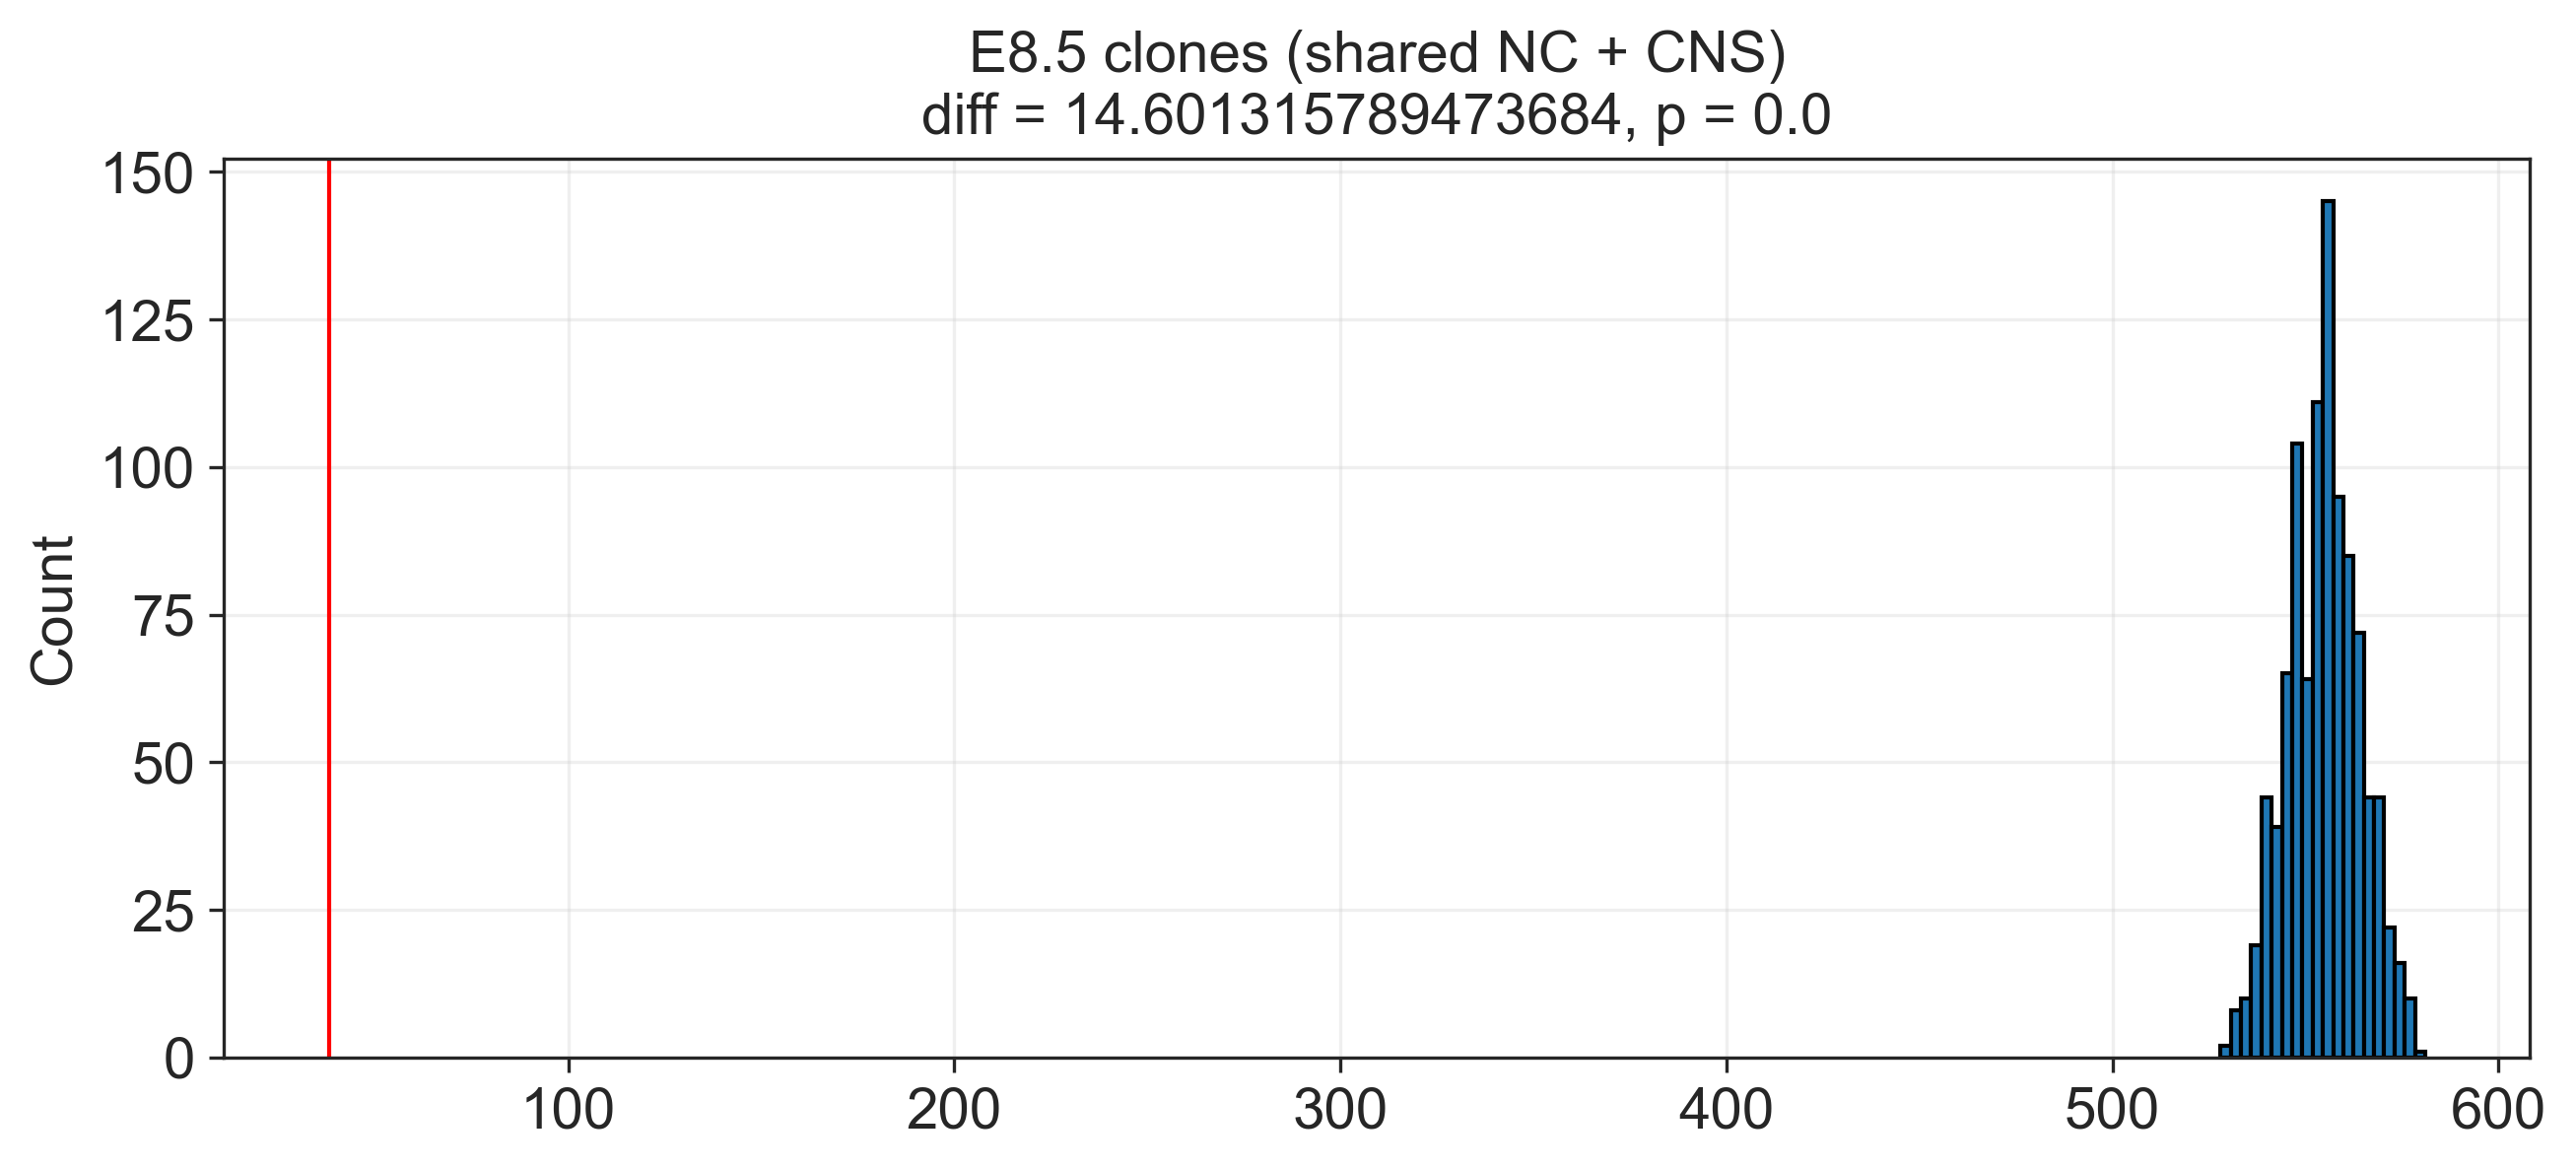

In [110]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(E8_shared_permut, bins=20, ax=ax, alpha=1, edgecolor="black")
ax.set_ylim(*ax.get_ylim())
ax.plot([E8_shared, E8_shared], [0, 1000], color="red", linewidth=1)

E8_shared_permut = np.array(E8_shared_permut)

p = (E8_shared_permut < E8_shared).sum() / len(E8_shared_permut)
diff = E8_shared_permut.mean() / E8_shared

ax.set_title(f"E8.5 clones (shared NC + CNS)\ndiff = {diff}, p = {p}")
ax.grid(alpha=0.3)

In [118]:
adata_n = adata_nnc[adata_nnc.obs.celltype_l2.isin(["Dorsal inhibitory", "Dorsal excitatory"])]

df_E7_neg = adata_n[adata_n.obs["E7.5:clones"] != "NA"].obs[["E7.5:clones", "celltype_l2"]]
df_E8_neg = adata_n[adata_n.obs["E8.5:clones"] != "NA"].obs[["E8.5:clones", "celltype_l2"]]

In [123]:
from tqdm import tqdm

E7_shared_permut_neg = []
E7_shared_neg = num_shared(df_E7_neg, "E7.5:clones", "celltype_l2")
num_permut = 1000

for i in tqdm(range(num_permut)):
    df_permut = pd.DataFrame({
        "E7.5:clones": df_E7_neg["E7.5:clones"],
        "celltype_l2": np.random.permutation(df_E7_neg["celltype_l2"]),
    })
    E7_shared_permut_neg.append(num_shared(df_permut, "E7.5:clones", "celltype_l2"))

100%|██████████| 1000/1000 [01:52<00:00,  8.89it/s]


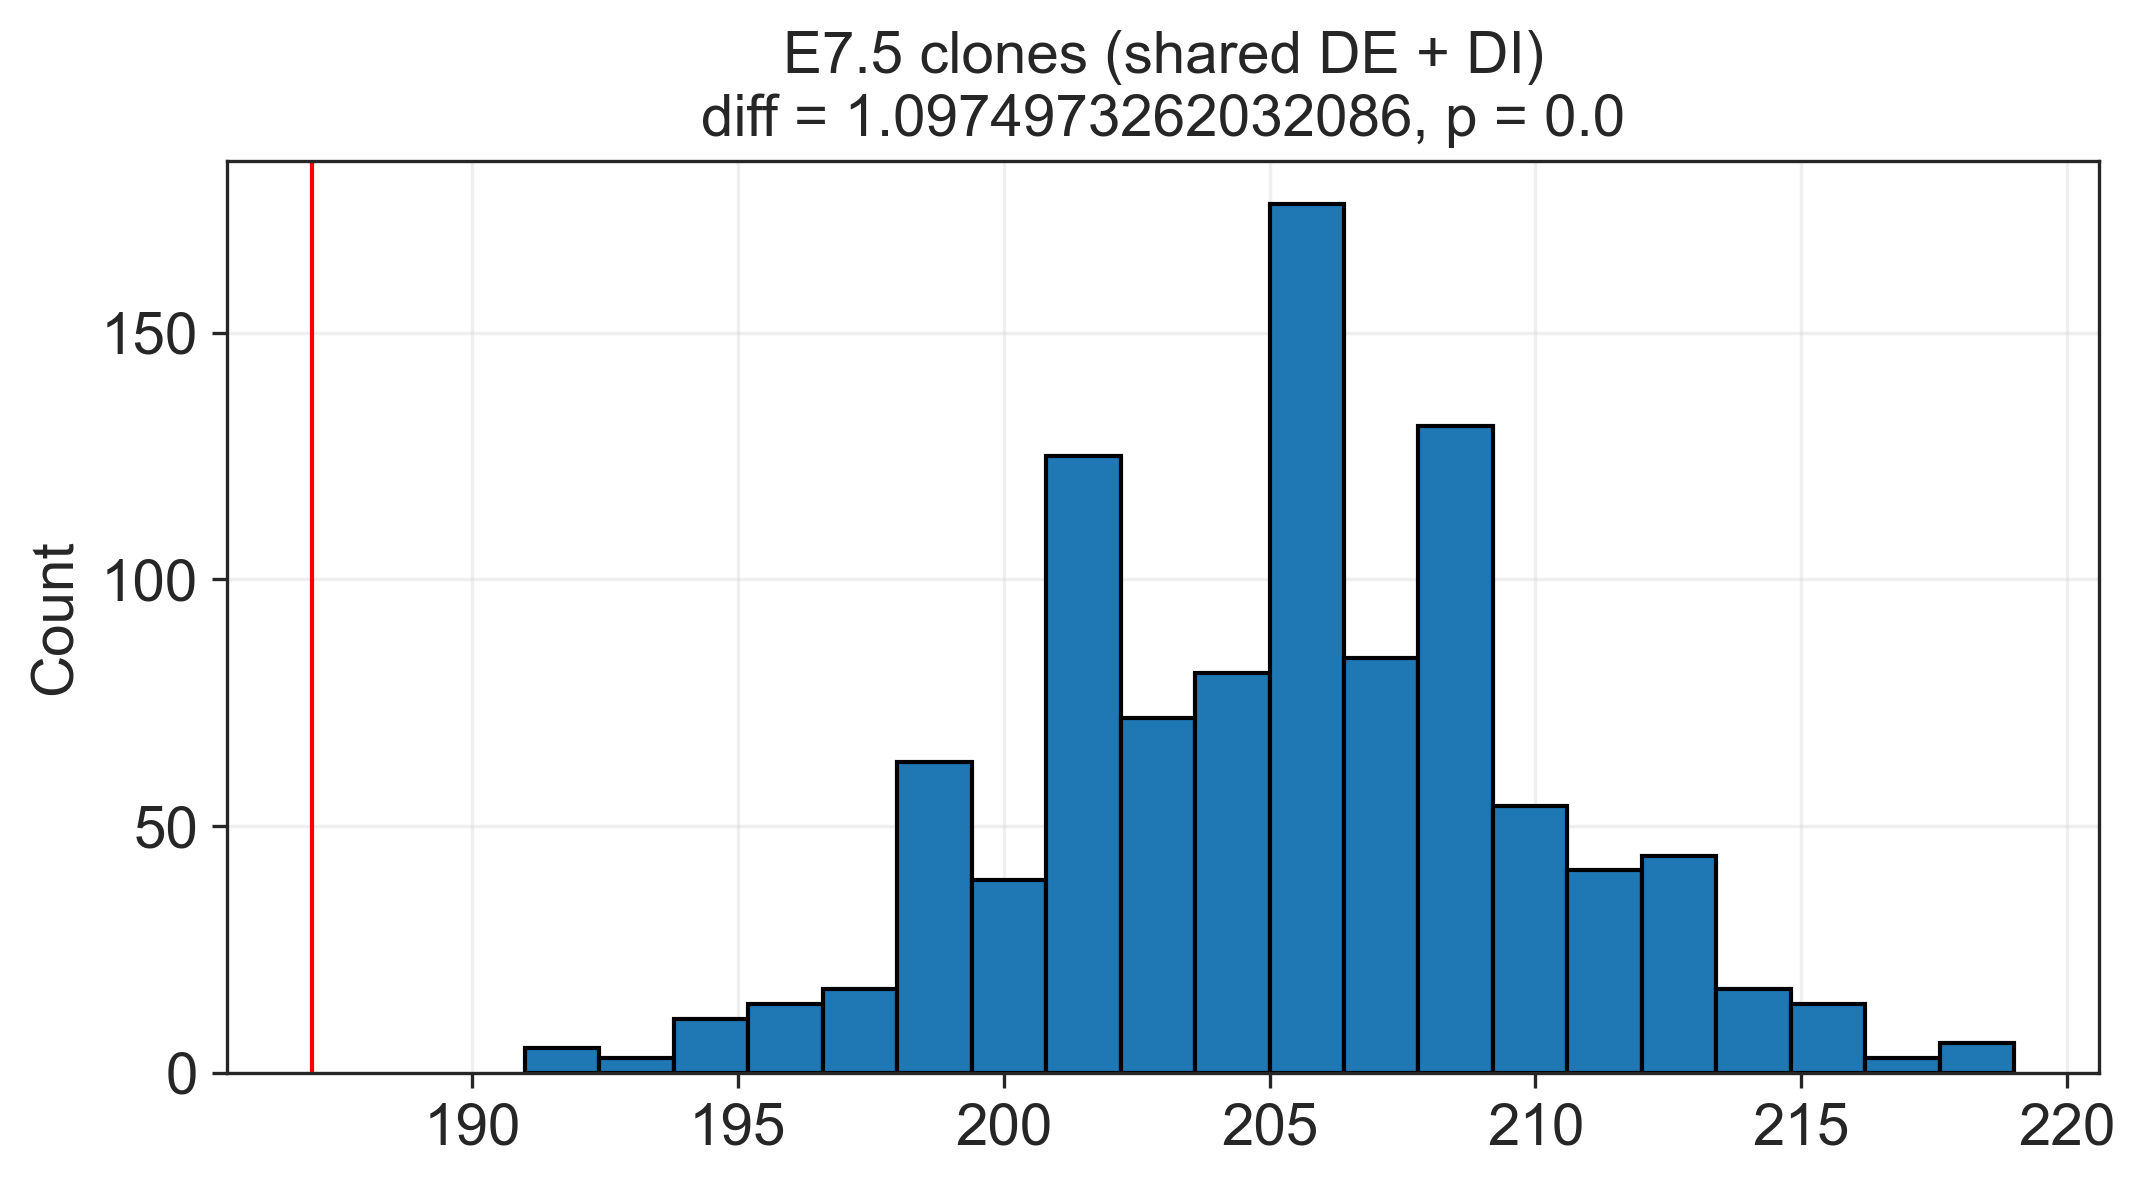

In [124]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(E7_shared_permut_neg, bins=20, ax=ax, alpha=1, edgecolor="black")
ax.set_ylim(*ax.get_ylim())
ax.plot([E7_shared_neg, E7_shared_neg], [0, 1000], color="red", linewidth=1)

E7_shared_permut_neg = np.array(E7_shared_permut_neg) 

p = (E7_shared_permut_neg < E7_shared_neg).sum() / len(E7_shared_permut)
diff = E7_shared_permut_neg.mean() / E7_shared_neg

ax.set_title(f"E7.5 clones (shared DE + DI)\ndiff = {diff}, p = {p}")
ax.grid(alpha=0.3)

In [125]:
from tqdm import tqdm

E8_shared_permut_neg = []
E8_shared_neg = num_shared(df_E8_neg, "E8.5:clones", "celltype_l2")
num_permut = 1000

for i in tqdm(range(num_permut)):
    df_permut = pd.DataFrame({
        "E8.5:clones": df_E8_neg["E8.5:clones"],
        "celltype_l2": np.random.permutation(df_E8_neg["celltype_l2"]),
    })
    E8_shared_permut_neg.append(num_shared(df_permut, "E8.5:clones", "celltype_l2"))

100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]


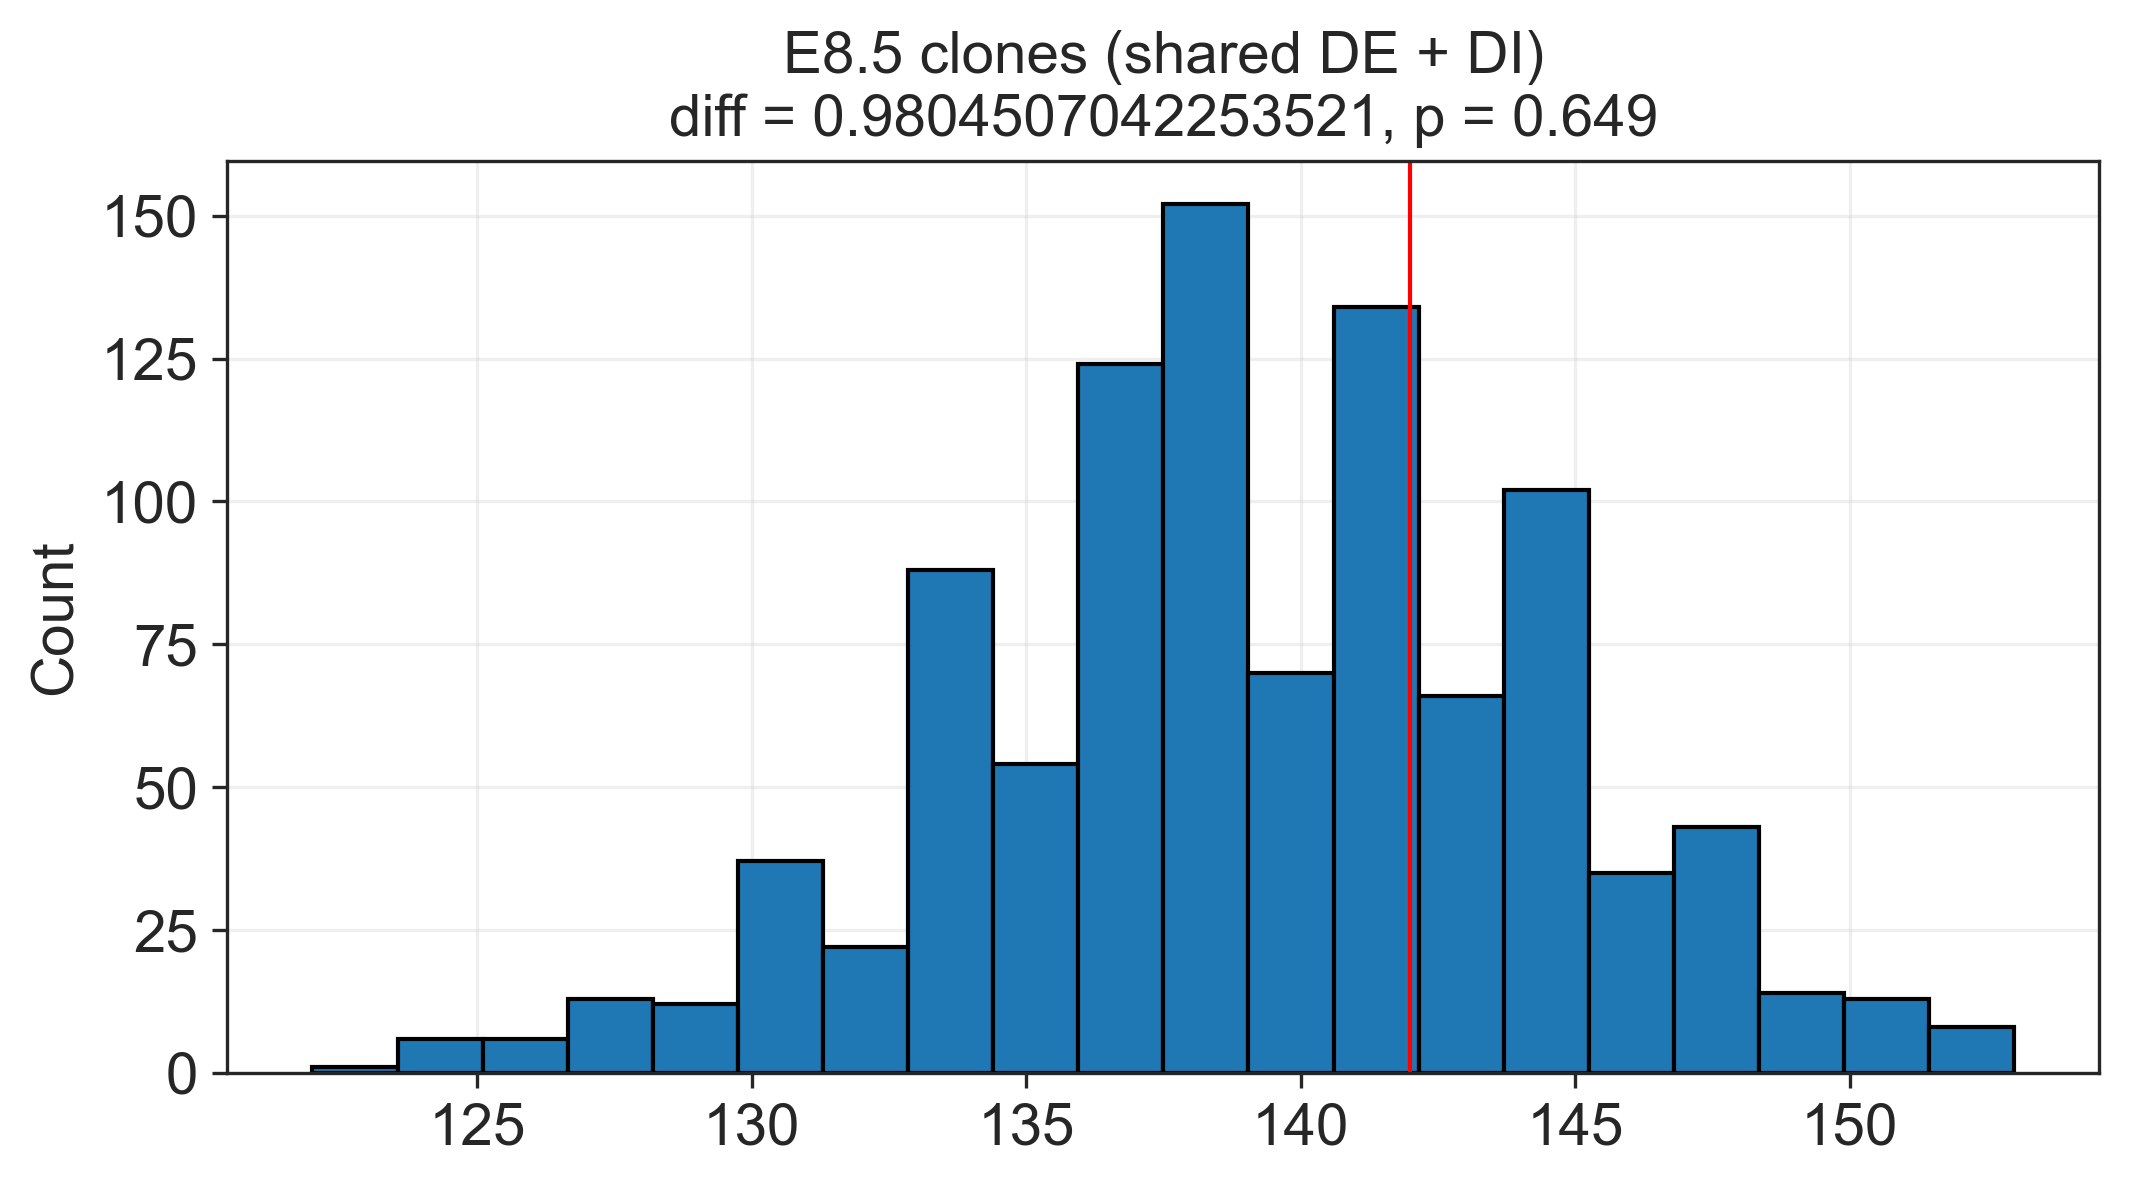

In [126]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(E8_shared_permut_neg, bins=20, ax=ax, alpha=1, edgecolor="black")
ax.set_ylim(*ax.get_ylim())
ax.plot([E8_shared_neg, E8_shared_neg], [0, 1000], color="red", linewidth=1)

E8_shared_permut_neg = np.array(E8_shared_permut_neg) 

p = (E8_shared_permut_neg < E8_shared_neg).sum() / len(E8_shared_permut)
diff = E8_shared_permut_neg.mean() / E8_shared_neg

ax.set_title(f"E8.5 clones (shared DE + DI)\ndiff = {diff}, p = {p}")
ax.grid(alpha=0.3)